# Chapter 5: Feature Importance and Feature Selection

In this chapter, we aim to answer key questions about our machine learning models: Which features are most critical for making accurate predictions? How can we reduce the feature space without sacrificing performance? What insights can feature importance provide about the data and model behavior? Can we quantitatively grasp what features have contributed to misclassifications and how? 

To address these questions, we explore techniques for quantifying feature importance, including SHAP values for interpretability, Random Forest importance for baseline comparisons. We then delve into feature selection methodologies like Recursive Feature Elimination (RFE) to systematically refine the feature set. Finally, we evaluate the impact of these selected features through retraining and performance analysis, demonstrating how effective feature selection can lead to more efficient, interpretable, and robust machine learning models.

## 5.1. Introduction to Feature Importance

Feature importance analysis serves several critical purposes that go beyond interpretability, making it a cornerstone of machine learning workflows. Its utility spans across various domains where understanding and optimizing models are crucial for actionable insights. Here are some of the reasons why feature importance is useful:

1. Interpretability: 
   Feature importance methods, especially SHAP values, directly address the need for interpretability. They allow us to link model predictions to specific feature contributions, making the results understandable to stakeholders. For instance, in healthcare, SHAP values can help explain why a particular patient was predicted to be at high risk for a disease, which is essential for trust and transparency in clinical decision-making.

2. Performance Optimization:
   Identifying the most relevant features enables the reduction of the feature space, leading to faster training times and reduced computational overhead without sacrificing performance. This is especially critical in finance, where models process large amounts of high-dimensional data, and selecting only key economic indicators or stock features can dramatically improve efficiency.

3. Error Analysis:
   Feature importance analysis highlights which features are most influential in misclassifications. This insight informs targeted interventions, such as creating better feature engineering pipelines, collecting additional data, or refining specific subsets of the dataset. For example, in fraud detection, identifying which features (e.g., transaction amounts or user behavior) contribute to false positives can guide improvements to reduce operational costs.

4. Guiding Hyperparameter Tuning: 
   By understanding the contributions of features, we can make informed decisions about model hyperparameters. For example, knowing which features dominate might guide decisions about regularization parameters or the depth of tree-based models. In marketing, where datasets often include hundreds of demographic and behavioral features, such insights can optimize model configurations for better campaign targeting.

5. Model-Specific Relevance:
   Unlike dimensionality reduction techniques, which create new composite features, feature importance preserves the original feature space. This is essential for understanding model behavior in terms of real-world variables. For example, in environmental studies, preserving the meaning of features like temperature, humidity, and CO\(_2\) levels is critical for drawing actionable conclusions.

6. Complementary Role in Feature Selection:  
   While feature selection aims to reduce the feature set for efficiency, feature importance methods inform and guide this process. For instance, Recursive Feature Elimination (RFE) can leverage feature importance scores to iteratively refine the feature subset. In domains like genomics, where thousands of genetic markers are evaluated, this combination is invaluable for identifying key contributors to traits or diseases.

### 5.1.1. Strengths and Weaknesses of Feature Analysis Methods

Feature analysis methods offer powerful tools for understanding and optimizing machine learning models, but each comes with its own set of advantages and limitations. Below, we provide an overview of the strengths and weaknesses of the key methods discussed in this chapter, along with examples of their use in various domains.

#### Feature Importance-Based Methods

1.  
   **SHAP values** provide fine-grained, instance-level explanations for each prediction. They can capture both linear and non-linear relationships in the model, offering both global and local interpretability. This versatility makes SHAP values suitable for use cases in healthcare, such as explaining why a patient was flagged for a particular condition or treatment. However, SHAP has several limitations. It is computationally expensive, particularly for large datasets or complex models, because it requires evaluating model predictions across many perturbed feature subsets to estimate contributions accurately. Approximation techniques like KernelSHAP or TreeSHAP can mitigate this to some extent, but they involve trade-offs in accuracy or flexibility. Additionally, SHAP results are sensitive to the underlying model, as they rely on its predictions, which can lead to inconsistent interpretations if the model changes. Finally, SHAP results can become challenging to interpret when the dataset includes a large number of features, as the detailed explanations may overwhelm practical usability. For our EMNIST project, while SHAP adds valuable insights, its full potential cannot be fully leveraged due to the specific characteristics of our problem and dataset.

2.  
   **Random Forest feature importances** provide a robust baseline for feature ranking, as they measure the average reduction in impurity caused by each feature. They are easy to compute and widely supported by machine learning libraries, making them accessible for use in diverse fields. For example, in agriculture, Random Forest feature importances might help identify which soil properties or climatic conditions most influence crop yields. However, these importances have limitations. They tend to be biased toward features with higher variance or a larger number of categories because the impurity reduction metric naturally favors features with more potential splits. This bias can result in overestimating the importance of such features while underestimating others. Additionally, Random Forest feature importances lack interpretability at the instance level. It provides only a global perspective of feature relevance across the entire dataset. Lastly, these feature importances are model-specific and may not generalize to other types of models which limits their applicability in cross-model comparisons.

3.  
   **Linear model coefficients** are intuitive and straightforward to interpret for understanding linear relationships. They are fast to compute and scale well to large datasets. This makes them a popular choice in fields like economics where understanding the direction of feature impact (e.g., a positive or negative effect of interest rates on inflation) is crucial. Despite these advantages, linear model coefficients have notable drawbacks. They assume linear relationships between features and the target variable, which may not always hold, especially in datasets with complex interactions. In cases where features are highly correlated, the coefficients can become unstable and produce misleading results due to multicollinearity. Techniques like regularization (e.g., Lasso or Ridge regression) can partially address this issue by penalizing large coefficients, but this can also lead to oversimplification. Furthermore, linear model coefficients are unsuitable for capturing non-linear interactions between features. This significantly limits their applicability to datasets with intricate relationships.

**Note** that in this chapter we are focusing on SHAP values and Random Forest feature importance because the models we are working with—thanks to their strong performance across many metrics— are tree-based. That is why we are skipping methods like Linear Model Coefficients in our deeper discussions. But we wanted to include them here to give you a well-rounded overview so if you’re interested in exploring those methods further, you’ve got a clear starting point.

## 5.2. Measuring Feature Importance

In this section, we dive into quantifying feature importance using two powerful methods: SHAP values and Random Forest feature importance. For SHAP, we leverage the best-performing XGBoost model from Chapter 3 after tuning.  But for the Random Forest feature importance, we rely on the tuned Random Forest model also obtained in Chapter 3.

### 5.2.1. SHAP Values

SHAP (SHapley Additive explanations) values are grounded in cooperative game theory and are used to fairly distribute the contribution of each feature to a model's prediction. The idea is to attribute the prediction $f(x)$ of a model $f$ to each feature $i$ based on its marginal contribution. **SHAP Value** are computed according to the following formula: 

> 
 > $
 \phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left[ f(S \cup \{i\}) - f(S) \right]
  $

where:
- $N$ is the set of all features,
- $S$ is a subset of features excluding $i$,
- $f(S)$ is the model's prediction when only the features in $S$ are included, and
- $\phi_i$ is the SHAP value for feature $i$.

#### Key Concepts Behind the Formula:
1. **Coalitional Game Setup**: Features are treated as players in a cooperative game, and the goal is to fairly distribute the "payout" (the model's prediction).
2. **Marginal Contribution**: The term $( f(S \cup \{i\}) - f(S) )$ measures the contribution of feature $i$ to the subset $S$.
3. **Shapley Weighting**: The term $( \frac{|S|!(|N|-|S|-1)!}{|N|!} )$ ensures fairness by considering all possible subsets $S$ and their sizes.

> **Additive Explanation Property**

> $f(x) = \phi_0 + \sum_{i=1}^{|N|} \phi_i$
>

The additive explanation property (the formula above) ensures that the sum of all SHAP values $\phi_i$ and the baseline value $\phi_0$ equals the model's prediction $f(x)$. Here, $\phi_0$ represents the average model prediction when no features are included (the baseline value), and $\phi_i$ captures the contribution of feature $i$. This property guarantees that every feature's influence is accounted for and that the sum of contributions exactly matches the prediction, preserving consistency and fairness.

#### Practical Computation
While the theoretical formula considers all subsets $S$, this is computationally expensive for models with many features ($2^{|N|}$ subsets). Practical implementations like TreeSHAP exploit the structure of tree-based models to compute SHAP values efficiently, making them feasible for large datasets.

#### Absolute SHAP Values vs. Signed SHAP Values

When analyzing SHAP values, it’s important to distinguish between **absolute SHAP values** and **signed SHAP values**:

1. **Absolute SHAP Values**:  
   These are computed by taking the absolute value of each SHAP contribution, $|\phi_i|$. This approach focuses on the magnitude of a feature’s impact, regardless of whether it increases or decreases the model’s prediction. Absolute SHAP values are particularly useful when the goal is to identify the most impactful features overall, without concern for the direction of their influence. This is the approach we use in our analysis to understand the regions of the image that contribute most strongly to predictions.

2. **Signed SHAP Values**:  
   In contrast, signed SHAP values retain the directionality of the contribution, with positive values indicating that a feature increases the prediction and negative values indicating that it decreases the prediction. Signed SHAP values are useful for understanding the polarity of feature contributions, which can provide insights into how specific features influence the model's decisions.

For our purposes, we are interested in the overall importance of features. So we use absolute SHAP values. This allows us to focus on identifying the features with the largest impact on the model's predictions, irrespective of whether their contributions are positive or negative. In future analyses, exploring signed SHAP values could help uncover deeper insights into how features push predictions in different directions.

In [93]:
import shap

def run_shap_whole_grid(model, subset_data, top_percentage=100):
    """
    runs SHAP on the entire grid of features and returns top important features.

    parameters:
        - model: trained XGBoost model
        - subset_data: np.ndarray, input data for SHAP
        - top_percentage: int, percentage of top features to return (e.g. if set to 50, top 50% of the important features are returned)

    returns:
        - shap_values: np.ndarray or list of np.ndarray, SHAP values for the subset
        - top_features: np.ndarray, indices of the top features (global mean)
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(subset_data)

    # handle scalar or unexpected SHAP outputs
    if isinstance(shap_values, (np.int64, int, float)):
        raise ValueError("SHAP values returned a scalar. Check model compatibility with SHAP.")

    # handle multi-class case
    if isinstance(shap_values, list):
        # Aggregate SHAP values across classes (mean absolute values)
        shap_values = np.mean([np.abs(vals) for vals in shap_values], axis=0)

    # mean absolute SHAP values for each feature across the dataset
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    # number of top features to return
    num_features = int(len(mean_shap_values) * (top_percentage / 100))

    # indices of top features
    top_features = np.argsort(mean_shap_values)[-num_features:][::-1]

    return shap_values, top_features

We run the SHAP method on a validation set of 10,000 randomly selected images. It is large enough to capture the diversity of the digit population but manageable enough to keep computational costs under control. Plus, since the images were drawn using stratified random sampling, we can be more confident that the set mirrors the overall dataset.

In [94]:
# generate SHAP values, all of the features considered to be returned for XGBoost best estimator of Chapter 3
shap_values, top_features = run_shap_whole_grid(best_estimators_dict['best_xgb'], validation_X_train, top_percentage=100)

In [95]:
def extract_shap_importance(shap_values, top_percentage=100):
    """
    extracts important feature indices for each image based on SHAP values.

    parameters:
        - shap_values: np.ndarray, SHAP values for the subset (n_samples, n_features)
        - top_percentage: int, percentage of top features to return

    returns:
        - important_features_per_image: list of np.ndarray, important feature indices for each image
    """
    n_features = shap_values.shape[1]
    num_top_features = int(n_features * (top_percentage / 100))

    important_features_per_image = []
    for i in range(shap_values.shape[0]):
        # Get top features for each image
        top_features = np.argsort(np.abs(shap_values[i]))[-num_top_features:][::-1]
        important_features_per_image.append(top_features)
    
    return important_features_per_image

In [97]:
important_features = extract_shap_importance(shap_values, top_percentage=100)

The function below visualizes the top_percentage of the SHAP values computed. `threshold` allows controlling what level of importance (for instance 95%) we are interested in visualizing. As a result any SHAP value below the `threshold` is not visualized.

Looking at the SHAP visualization for the digit 8, you can see that the brightest regions (yellow to white) are concentrated near the center and along the diagonal. These represent the features contributing most to the model’s predictions. Interestingly, this aligns with the observations from our Exploratory Data Analysis in Section 1.2.2, where the mean image for digit 8 highlighted the central strokes and diagonal structure as defining characteristics.

The variance images further complement this understanding. Pixels closer to the center tend to have higher variability, reflecting the digit's defining strokes, while pixels further out—darker in the SHAP visualization—carry less information and contribute less to the model’s decisions. These peripheral pixels deviate more from the mean and are likely less important for distinguishing the digit.
This alignment between the SHAP analysis and our earlier exploration provides a cohesive perspective on how the model identifies key features for predictions. The SHAP values emphasize regions that are consistent with the digit's structure, offering a better understanding of how the model prioritizes features.

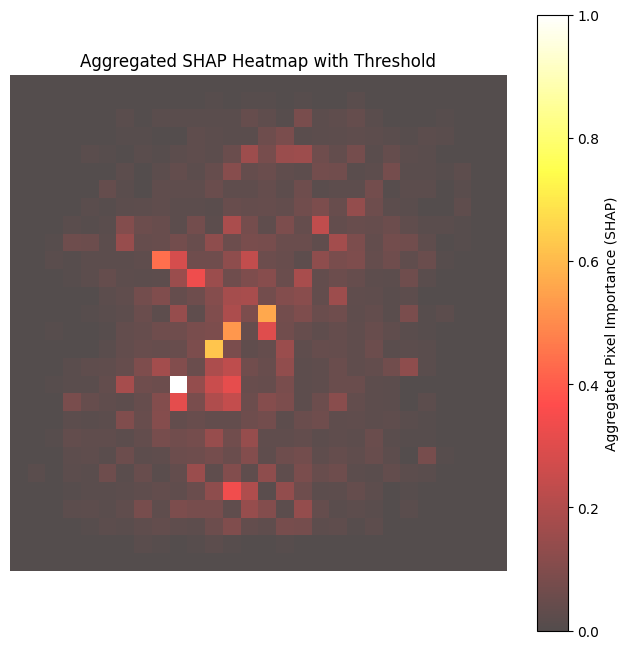

In [98]:
def visualize_shap_with_threshold(important_features, grid_size=(28, 28), threshold=0.01, average_image=None):
    """
    Visualizes the aggregated SHAP heatmap with a threshold to filter low-importance pixels.

    Parameters:
        - important_features: list of np.ndarray, ranked feature indices for each image
        - grid_size: tuple, dimensions of the image grid (height, width)
        - threshold: float, minimum SHAP importance to visualize
        - average_image: np.ndarray, optional average image to overlay as context

    Returns:
        - None
    """
    
    # initialize an empty grid to accumulate importance scores
    aggregated_importance = np.zeros(grid_size, dtype=float)

    # accumulate SHAP scores based on rank
    for ranked_features in important_features:
        for rank, feature_index in enumerate(ranked_features):
            row, col = divmod(feature_index, grid_size[1])
            aggregated_importance[row, col] += 1.0 / (rank + 1)

    # normalize and apply threshold
    aggregated_importance /= aggregated_importance.max()
    aggregated_importance[aggregated_importance < threshold] = 0  # Remove very low importance

    # plot the heatmap
    plt.figure(figsize=(8, 8))
    if average_image is not None:
        plt.imshow(average_image, cmap="gray", alpha=0.5)  # Optional average image
    plt.imshow(aggregated_importance, cmap="hot", interpolation="nearest", alpha=0.7)
    plt.colorbar(label="Aggregated Pixel Importance (SHAP)")
    plt.title("Aggregated SHAP Heatmap with Threshold")
    plt.axis("off")
    plt.show()

#average_image = shap_subset_1.mean(axis=0).reshape(28, 28)
visualize_shap_with_threshold(important_features, grid_size=(28, 28), threshold=0.01)

These findings reinforce the observation that central and diagonal regions have a higher influence in characterizing the digit, while peripheral pixels deviate more from the mean and carry less predictive value.

### 5.2.1.1. Class-Wise SHAP Importance

While absolute SHAP importance provides a global overview of feature relevance across all images, it does not account for variations between different classes. Certain features may be important overall but serve distinctly different roles for specific classes. To uncover these class-specific patterns, we compute and visualize SHAP importance at the class level.

In [99]:
# Class-wise Importance: Measure which pixels are most important for specific classes.

def compute_top_class_wise_features(shap_values, labels, top_percentage=10, grid_size=(28, 28), num_classes=10):
    """
    Computes the top N% important features for each class.

    Parameters:
        - shap_values: np.ndarray, SHAP values for all validation images (n_samples, n_features).
        - labels: np.ndarray, true class labels for each image.
        - top_percentage: float, percentage of top features to retain (0-100).
        - grid_size: tuple, dimensions of the image grid (height, width).
        - num_classes: int, number of unique classes.

    Returns:
        - top_class_importances: dict, mapping of class index to top N% SHAP importance heatmap.
    """
    top_class_importances = {}

    for cls in range(num_classes):
        # get indices for the current class
        class_indices = np.where(labels == cls)[0]
        class_shap_values = shap_values[class_indices]

        # compute mean absolute SHAP values for this class
        mean_shap_values = np.abs(class_shap_values).mean(axis=0)

        # determine the threshold for the top N% features
        num_features = mean_shap_values.size
        num_top_features = int(num_features * (top_percentage / 100))
        top_feature_indices = np.argsort(mean_shap_values)[-num_top_features:]

        # create a heatmap with only the top N% features
        top_shap_heatmap = np.zeros_like(mean_shap_values)
        top_shap_heatmap[top_feature_indices] = mean_shap_values[top_feature_indices]
        top_class_importances[cls] = top_shap_heatmap.reshape(grid_size)

    return top_class_importances

def visualize_top_class_wise_features(top_class_importances, top_percentage=None):
    """
    Visualizes the top N% SHAP importance heatmaps for each class.

    Parameters:
        - top_class_importances: dict, mapping of class index to top N% SHAP importance heatmap.

    Returns:
        - None
    """
    num_classes = len(top_class_importances)
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

    for cls, ax in zip(top_class_importances.keys(), axes):
        ax.imshow(top_class_importances[cls], cmap="hot", interpolation="nearest")
        ax.axis("off")
        ax.set_title(f"Class {cls} (Top_{top_percentage}%)")

    plt.tight_layout()
    plt.show()

#### Class-Wise SHAP Analysis

For each digit, we visualize below the top 30% of important features (pixels) identified by their SHAP values. These visualizations are based on the 8-vs-all binary classifier, which serves as our reference model. It’s important to note that the results may vary if a different model is used (e.g., 1-vs-all), as feature importance depends on the specific classifier and the underlying decision boundaries it learns.

We here focus only elaborate on the case of images corresponding to digit 6. Once again, note that our SHAP calculations, hence our perspective, is limited by what the trained XGBoost 8-vs-all model is presenting us. The SHAP importance heatmap for Class 6 highlights key regions of the image that the model relies on most heavily when identifying this digit. Notably, brighter regions (yellow to white) correspond to the most influential pixels based on SHAP values, while darker regions (red to black) represent less important areas.

#### Observations for Digit 6:
1. **Central Importance**: The central loop and the surrounding curved structure are consistently among the most important regions. This reflects the model’s reliance on the defining loop shape at the bottom of the digit 6, which helps distinguish it from similar digits like 0 and 9.
   
2. **Top-to-Bottom Transition**: The SHAP importance extends along the curve from the top opening to the lower loop. This pattern suggests that the model leverages the open-top structure to differentiate 6 from closed-loop digits like 8 and 0.

3. **Comparison to Other Classes**:
   - Compared to **Class 0** or **Class 8**, the heatmap for Class 6 emphasizes the asymmetry introduced by the open top and the sharper curve toward the bottom.  
   - Unlike **Class 9**, which also has a loop, the SHAP importance for Class 6 focuses more on the transition into the bottom loop, indicating the model distinguishes the digits based on these finer structural details.

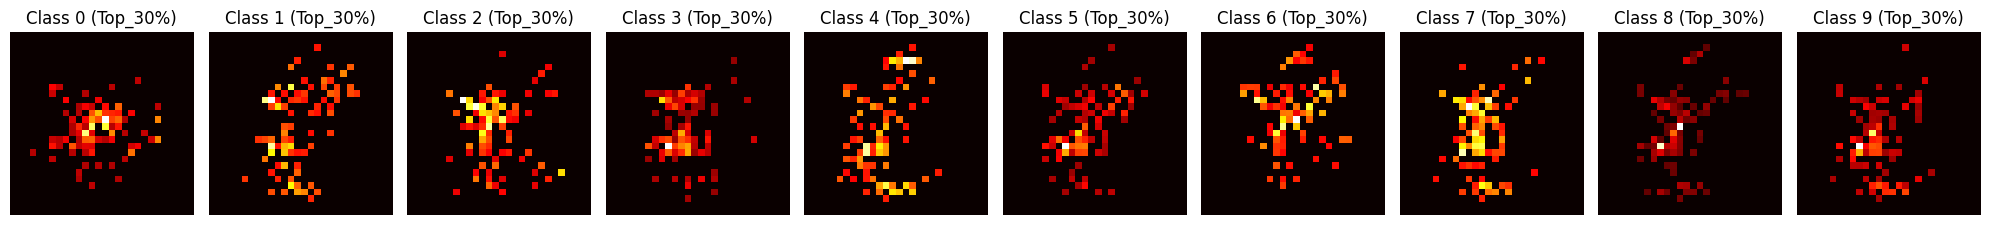

In [100]:
top_class_importances = compute_top_class_wise_features(
    shap_values, validation_y, grid_size=(28, 28), num_classes=10
)

visualize_top_class_wise_features(top_class_importances, top_percentage=30)

### 5.2.1.2. Consistently Top Features

The compute_top_features function identifies features (pixels) that ***consistently*** appear among the top-ranked SHAP values across all images, helping us uncover which regions are universally significant for the model's predictions. For each image, it selects the top  $N$ features with the highest absolute SHAP values, aggregates them across all images, and counts their frequency. These frequencies are then sorted to highlight features that consistently have the highest importance.

We parameterize the selection with  $N = 262$ which represents one-third of the total features in each image. This choice is based on our findings in Section 1.2.1, where we observed that only about one-third of the pixels are non-zero across classes. By aligning the analysis with this natural sparsity, we ensure that our approach focuses on meaningful pixels while maintaining computational efficiency.

In [101]:
# Feature Consistency: Identify pixels/features that consistently appear in the top N SHAP values across all images.
def compute_top_features(shap_values, top_n=262):
    """
    Computes the most consistently important features across all images.

    Parameters:
        - shap_values: np.ndarray, SHAP values for all images (n_samples, n_features)
        - top_n: int, number of top features to identify

    Returns:
        - feature_counts: dict, feature indices and their frequency in the top N
    """
    top_features = []
    for shap_image in shap_values:
        top_features.extend(np.argsort(np.abs(shap_image))[-top_n:])

    unique, counts = np.unique(top_features, return_counts=True)
    feature_counts = dict(zip(unique, counts))
    return sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)


top_features = compute_top_features(shap_values, top_n=262)

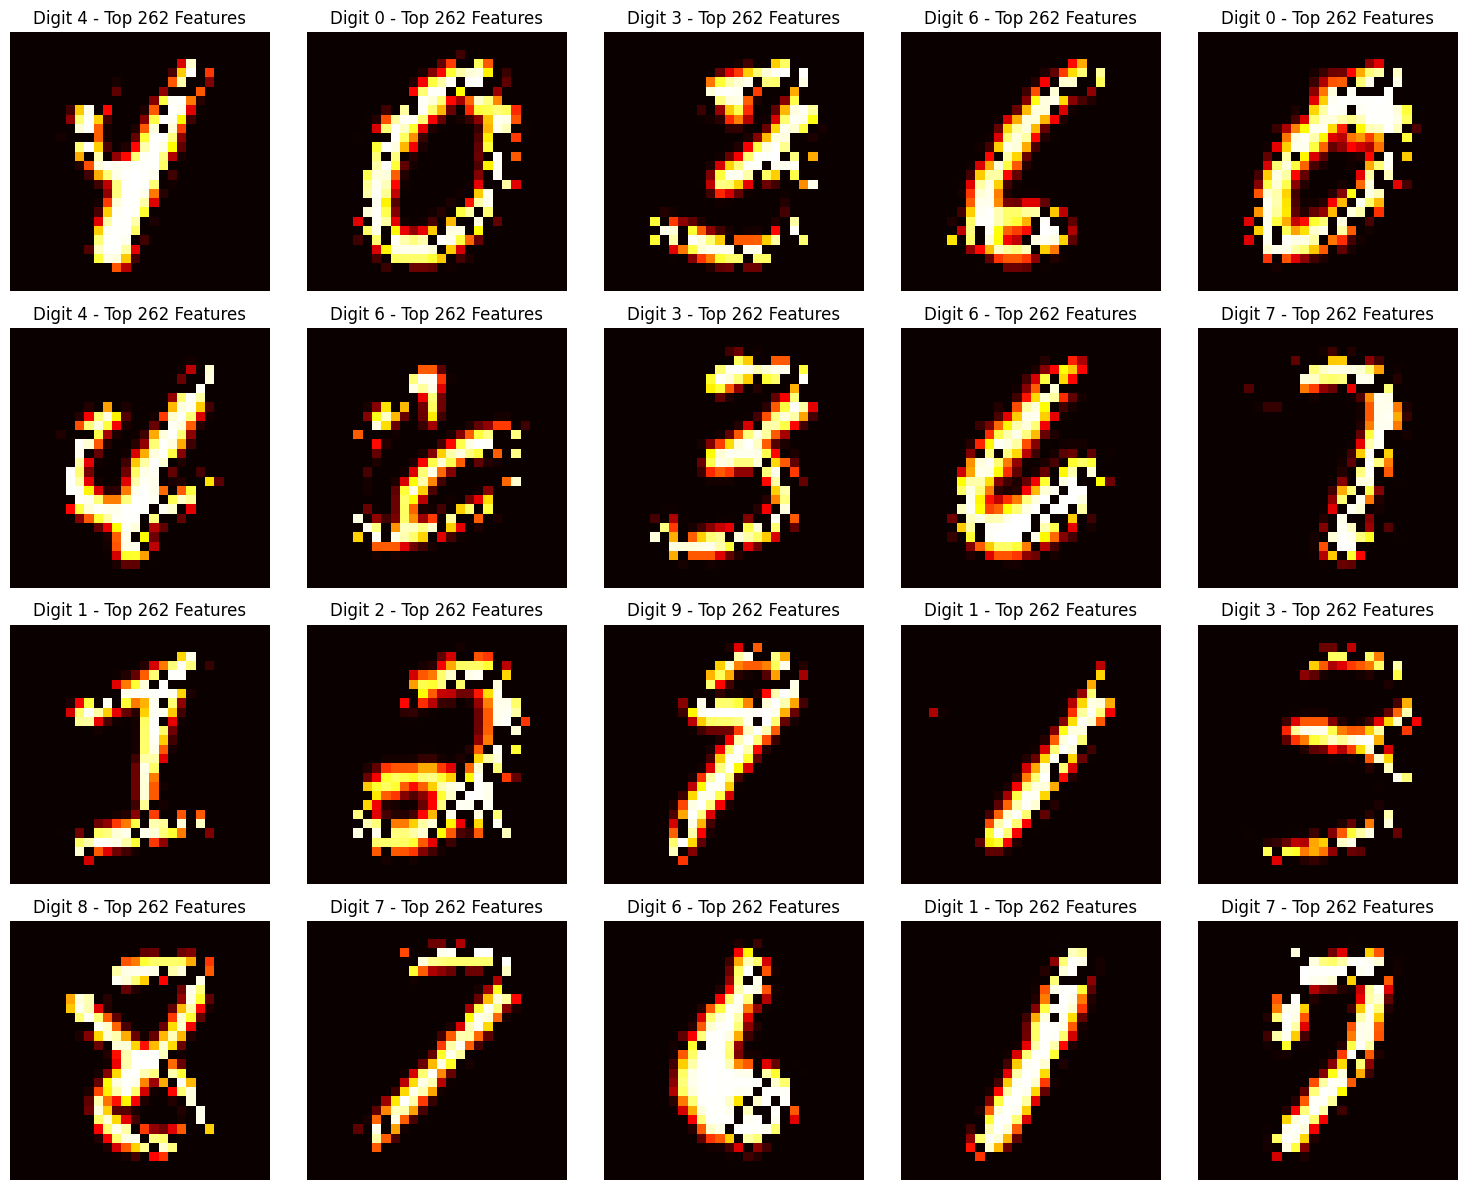

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_top_n_features(images, y_labels, top_features, top_n, grid_size=(28, 28), num_images=10):
    """
    Visualizes only the top N important features (pixels) on the input images, with labels displayed.

    Parameters:
        - images: np.ndarray, original images (n_samples, n_features)
        - y_labels: np.ndarray, true labels corresponding to the images
        - top_features: list of tuples [(feature_index, count)], output from compute_top_features
        - top_n: int, number of top features to retain for visualization
        - grid_size: tuple, dimensions of the image grid (height, width)
        - num_images: int, number of images to visualize

    Returns:
        - None
    """
    # extract the top N feature indices
    top_feature_indices = [idx for idx, _ in top_features[:top_n]]

    # select random images to visualize
    selected_indices = np.random.choice(len(images), size=min(num_images, len(images)), replace=False)
    selected_images = images[selected_indices]
    selected_labels = y_labels[selected_indices]  # corresponding true labels

    # plot each image, showing only the top N features
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Round up
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(selected_images):
            # reshape image and create a mask for the top N features
            original_image = selected_images[i].reshape(grid_size)
            mask = np.zeros_like(original_image)

            for feature_index in top_feature_indices:
                row, col = divmod(feature_index, grid_size[1])
                mask[row, col] = original_image[row, col]  # retain only top N features

            # visualize the masked image
            ax.imshow(mask, cmap="hot", interpolation="nearest")
            ax.axis("off")
            ax.set_title(f"Digit {selected_labels[i]} - Top {top_n} Features")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


visualize_top_n_features(validation_X_train, validation_y, top_features, top_n=262, grid_size=(28, 28), num_images=20)

### 5.2.2. Random Forest Feature Importance: Static vs. Recursive Feature Elimination (RFE)

Random Forests offer two powerful approaches to feature importance: static importance through the `feature_importances_` attribute and dynamic importance via Recursive Feature Elimination (RFE). Each method provides unique insights into feature relevance, with distinct trade-offs in terms of computational cost, dependency awareness, and suitability for feature selection.

#### Static Feature Importance 
This approach computes feature importance directly from the trained model using metrics like Gini impurity reduction or information gain. It provides a quick, global ranking of features, offering initial insights into their contributions to the model. However, static importance does not account for feature dependencies, such as correlations or redundancy, and may overemphasize features with high cardinality or noise.

#### Recursive Feature Elimination (RFE) 
RFE, on the other hand, dynamically adjusts feature rankings by iteratively removing the least important features and retraining the model. This process makes RFE robust to redundancy and better suited for identifying optimal feature subsets. However, it is computationally expensive and sensitive to hyperparameters, making it less practical for large datasets or high-dimensional feature spaces.

#### Comparing Static Feature Importance and Recursive Feature Elimination (RFE)

Static feature importance and Recursive Feature Elimination (RFE) offer complementary approaches to understanding feature relevance in Random Forest models. While both methods help identify important features, they differ significantly in how they operate, their computational demands, and their suitability for specific use cases.

| **Aspect**                      | **Static Feature Importance**   | **RFE**                     |
|----------------------------------|----------------------------------|------------------------------|
| **Computation**                 | Fast and efficient              | Computationally expensive   |
| **Dependency Awareness**        | Does not consider correlations  | Accounts for feature redundancy and dependencies |
| **Robustness to Noise**         | May overemphasize noisy features | More robust by iteratively removing noisy features |
| **Feature Selection**           | Provides global feature ranking | Identifies optimal feature subsets |
| **Interpretability**            | Quick insights into feature relevance | Dynamic but requires more steps to interpret |

#### Key Trade-Offs
- **Efficiency vs. Depth**: Static feature importance is quick to compute and useful for gaining initial insights, while RFE provides a deeper analysis by considering feature interdependencies.
- **When to Use Static Importance**: Best suited for exploratory analysis or when computational resources are limited.
- **When to Use RFE**: Ideal for workflows requiring dependency-aware feature selection or optimized feature subsets, especially when dimensionality reduction is a priority.

We shall discuss static importance as a starting point for understanding global relevance. Afterwards we dive into RFE which refines this understanding by dynamically adjusting feature rankings based on model performance.

### 5.2.2.1. Static Feature Importance

One of the main purposes of this chapter, as hinted earlier, is to better understand both the tuned models and the dataset used for training. By learning about feature importance from different perspectives, we can uncover insights into how models make predictions and what patterns in the data drive these decisions.

The 8-vs-all model provides valuable information, but its scope is limited to identifying which pixels are important for distinguishing digit 8 from all others. To gain a complete picture, we extend our analysis by training one-vs-all Random Forest models for each digit. This allows us to examine which features matter most for separating each digit from the rest, filling in the gaps left by the 8-vs-all approach. Moreover, these per-digit insights give us the leverage to aggregate feature importance across all models, offering a global view of critical features that can later inform feature selection.

To ensure consistency in our analysis, all one-vs-all models are trained using the same hyperparameters identified in Chapter 3 for the 8-vs-all Random Forest model. This mirrors our SHAP-based analysis, which relied on the best XGBoost model from the same chapter. By tying feature importance directly to the tuning and model development discussed in Chapter 3, this approach highlights the integral role of feature analysis in understanding and optimizing the pipeline as a whole.

In [103]:
import seaborn as sns

class OneVsAllRandomForest:
    def __init__(self, X_train, y_train, best_rf, digits=None):
        """
        initializes the One-vs-All Random Forest trainer.
        
        parameters:
            - X_train: np.ndarray, feature matrix.
            - y_train: np.ndarray, true labels for the data.
            - best_rf: Trained Random Forest model (used for extracting best hyperparameters).
            - digits: list of int, digits to train one-vs-all models for. If None, defaults to digits 1-9.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.best_rf = best_rf
        self.digits = digits if digits else list(range(10))
        self.rf_models = {}
        self.feature_importances = {}
        self.normalized_importances = {}
        self.aggregated_importances = None

    def train_one_vs_all_rfs(self):
        """
        trains one-vs-all Random Forest models for the specified digits.
        """
        # extract hyperparameters from best_rf
        best_params = {
            'n_estimators': self.best_rf.n_estimators,
            'max_depth': self.best_rf.max_depth,
            'min_samples_split': self.best_rf.min_samples_split,
            'max_features': self.best_rf.max_features,
            'min_samples_leaf': self.best_rf.min_samples_leaf
        }

        for digit in self.digits:
            print(f"Training Random Forest for digit {digit} vs. all...")
            # Create binary labels: True for the current digit, False for all others
            y_binary = (self.y_train == digit).astype(int)

            # train Random Forest
            rf_model = RandomForestClassifier(
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'],
                min_samples_split=best_params['min_samples_split'],
                max_features=best_params['max_features'],
                min_samples_leaf=best_params['min_samples_leaf'],
                random_state=42
            )
            rf_model.fit(self.X_train, y_binary)

            # store the model with the key "best_rf_d"
            self.rf_models[f"best_rf_{digit}"] = rf_model

    def extract_feature_importances(self):
        """
        extracts feature importances from trained Random Forest models.
        """
        for name, model in self.rf_models.items():
            print(f"Extracting feature importances for {name}...")
            self.feature_importances[name] = model.feature_importances_

    def normalize_feature_importances(self):
        """
        normalizes feature importances for each model to sum to 1.
        """
        for name, importances in self.feature_importances.items():
            self.normalized_importances[name] = importances / np.sum(importances)

    def aggregate_feature_importances(self, method="mean"):
        """
        aggregates feature importances across all models using the specified method.
        
        Parameters:
            - method: str, aggregation method ("mean", "sum", or "max").
        """
        importance_matrix = np.array(list(self.normalized_importances.values()))

        if method == "mean":
            self.aggregated_importances = np.mean(importance_matrix, axis=0)
        elif method == "sum":
            self.aggregated_importances = np.sum(importance_matrix, axis=0)
        elif method == "max":
            self.aggregated_importances = np.max(importance_matrix, axis=0)
        else:
            raise ValueError("Invalid aggregation method. Choose from 'mean', 'sum', or 'max'.")

    def visualize_digit_feature_importance(self, digit, grid_size=(28, 28)):
        """
        visualizes feature importance for a specific digit's d-vs-all Random Forest.
    
        parameters:
            - digit: int, the digit for which to visualize feature importance.
            - grid_size: tuple, dimensions of the feature grid (e.g., (28, 28) for MNIST).
    
        returns:
            - None. Displays a heatmap of feature importances.
        """
        model_name = f"best_rf_{digit}"
        if model_name not in self.feature_importances:
            raise ValueError(f"Feature importance for digit {digit} has not been computed. Ensure the d-vs-all model is trained and feature_importances are extracted.")

        # get the feature importances for the specific model
        feature_importances = self.feature_importances[model_name]

        # reshape to grid size
        importance_grid = feature_importances.reshape(grid_size)

        # plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            importance_grid,
            annot=False,
            cmap="viridis",
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False
        )
        plt.title(f"Feature Importance Heatmap for Digit {digit} (One-vs-All RF)", fontsize=16)
        plt.xlabel("Feature X-Axis", fontsize=12)
        plt.ylabel("Feature Y-Axis", fontsize=12)
        plt.show()

    def visualize_all_digits_feature_importance(self, grid_size=(28, 28), digits=None, n_cols=3):
        """
        visualizes feature importances for all d-vs-all Random Forests in a grid layout.
    
        parameters:
            - grid_size: tuple, dimensions of the feature grid (e.g., (28, 28) for MNIST).
            - digits: list of int or None, the digits to visualize. If None, defaults to trained digits.
            - n_cols: int, number of columns for the visualization grid.
    
        returns:
            - None. Displays a grid of heatmaps.
        """
        if digits is None:
            digits = self.digits  # default to trained digits

        n_digits = len(digits)
        n_rows = (n_digits + n_cols - 1) // n_cols  # compute required rows (rounding up)

        # Create the figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axes = axes.flatten()

        for i, digit in enumerate(digits):
            ax = axes[i]
            model_name = f"best_rf_{digit}"
            if model_name not in self.feature_importances:
                raise ValueError(f"Feature importance for digit {digit} has not been computed. Ensure the d-vs-all model is trained and feature_importances are extracted.")
        
            # get the feature importances for the specific model
            feature_importances = self.feature_importances[model_name]
            importance_grid = feature_importances.reshape(grid_size)

            # plot the heatmap
            sns.heatmap(
                importance_grid,
                annot=False,
                cmap="viridis",
                cbar=False,
                square=True,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )
            ax.set_title(f"Digit {digit}", fontsize=14)
            ax.axis("off")

        # turn off unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        # adjust layout
        plt.tight_layout()
        plt.show()

    def visualize_aggregated_importances(self, grid_size=(28, 28)):
        """
        visualizes aggregated feature importances as a heatmap.
        """
        if self.aggregated_importances is None:
            raise ValueError("Aggregated importances not computed. Call `aggregate_feature_importances()` first.")

        # reshape to grid size
        importance_grid = self.aggregated_importances.reshape(grid_size)

        # plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            importance_grid,
            annot=False,
            cmap="viridis",
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False
        )
        plt.title("Aggregated Feature Importance Heatmap (One-vs-All Random Forests)", fontsize=16)
        plt.xlabel("Feature X-Axis", fontsize=12)
        plt.ylabel("Feature Y-Axis", fontsize=12)
        plt.show()

In [104]:
# initialize the class
rf_trainer = OneVsAllRandomForest(
    X_train=X_train,
    y_train=y_train,
    best_rf=best_estimators_dict['best_rf']
)

In [105]:
# step 1: train one-vs-all models

rf_trainer.train_one_vs_all_rfs()

Training Random Forest for digit 0 vs. all...
Training Random Forest for digit 1 vs. all...
Training Random Forest for digit 2 vs. all...
Training Random Forest for digit 3 vs. all...
Training Random Forest for digit 4 vs. all...
Training Random Forest for digit 5 vs. all...
Training Random Forest for digit 6 vs. all...
Training Random Forest for digit 7 vs. all...
Training Random Forest for digit 8 vs. all...
Training Random Forest for digit 9 vs. all...


In [166]:
# step 2: extract feature importances

rf_trainer.extract_feature_importances()

Extracting feature importances for best_rf_0...
Extracting feature importances for best_rf_1...
Extracting feature importances for best_rf_2...
Extracting feature importances for best_rf_3...
Extracting feature importances for best_rf_4...
Extracting feature importances for best_rf_5...
Extracting feature importances for best_rf_6...
Extracting feature importances for best_rf_7...
Extracting feature importances for best_rf_8...
Extracting feature importances for best_rf_9...


We need to normalize the results obtained from different models. You may wonder why Normalize Feature Importances?
Normalization ensures that the feature importances from each one-vs-all model are directly comparable, regardless of differences in the scale of the raw importance values. This is particularly important when aggregating importances across models, as it ensures that each model contributes equally to the final aggregated importance, preventing any single model from disproportionately influencing the results.

In [167]:
# step 3: normalize feature importances

rf_trainer.normalize_feature_importances()

We aggregate the results obtained from every one-vs-all model. Aggregating across all models emphasizes feature consistency, identifying pixels that are repeatedly important for distinguishing multiple digits.

In [168]:
# step 4: Aggregate feature importances (mean, sum, or max)

rf_trainer.aggregate_feature_importances(method="mean")

### Aggregated Feature Importance for Digit 8

The aggregated feature importance for digit 8 emphasizes two distinct regions: the **central vertical spine** connecting the upper and lower loops, and the **left and right boundaries of the loops themselves**. These regions align closely with the structural characteristics of digit 8, which relies on its symmetry and the connection between its loops for recognition. Interestingly, the Random Forest model identifies these areas as the most critical, which highlights its reliance on features that capture the overall shape of the digit.

### Contrasting Digit 8 with Digit 9

When we compare digit 8 to digit 9, an intriguing pattern emerges. Both digits share common regions of importance—most notably, the **upper loop of digit 8** overlaps with the upper circular region of digit 9. Additionally, the **left side of the lower loop in digit 8** also holds significance in both 8-vs-all and 9-vs-all models, though with varying emphasis.

These shared regions highlight **potential zones of distributional overlap**, where variations of digit 8 resemble digit 9 and vice versa. This overlap may lead to misclassifications, especially for outliers that stray into the other's distribution. For instance, a digit 8 with a flattened or exaggerated upper loop might resemble a digit 9. As seen in the heatmaps, the model's focus on these regions reflects its sensitivity to such variations.

### The Role of Tree-Based Models in Misclassification

Tree-based models like Random Forests and XGBoost add complexity to this phenomenon. By relying on randomized feature splits and hyperparameters such as `max_features`, `max_leaf_nodes`, and `n_estimators`, these models may overemphasize shared features like the overlapping loop areas. Without sufficient depth or properly tuned parameters, they may fail to effectively distinguish between digits, increasing misclassifications.

For example, a tree split using the left side of the lower loop as a feature might result in decision boundaries that inadequately separate digits 8 and 9. As shown in the visualizations, careful hyperparameter tuning is crucial to balance reliance on such features while exploring deeper patterns in the data.

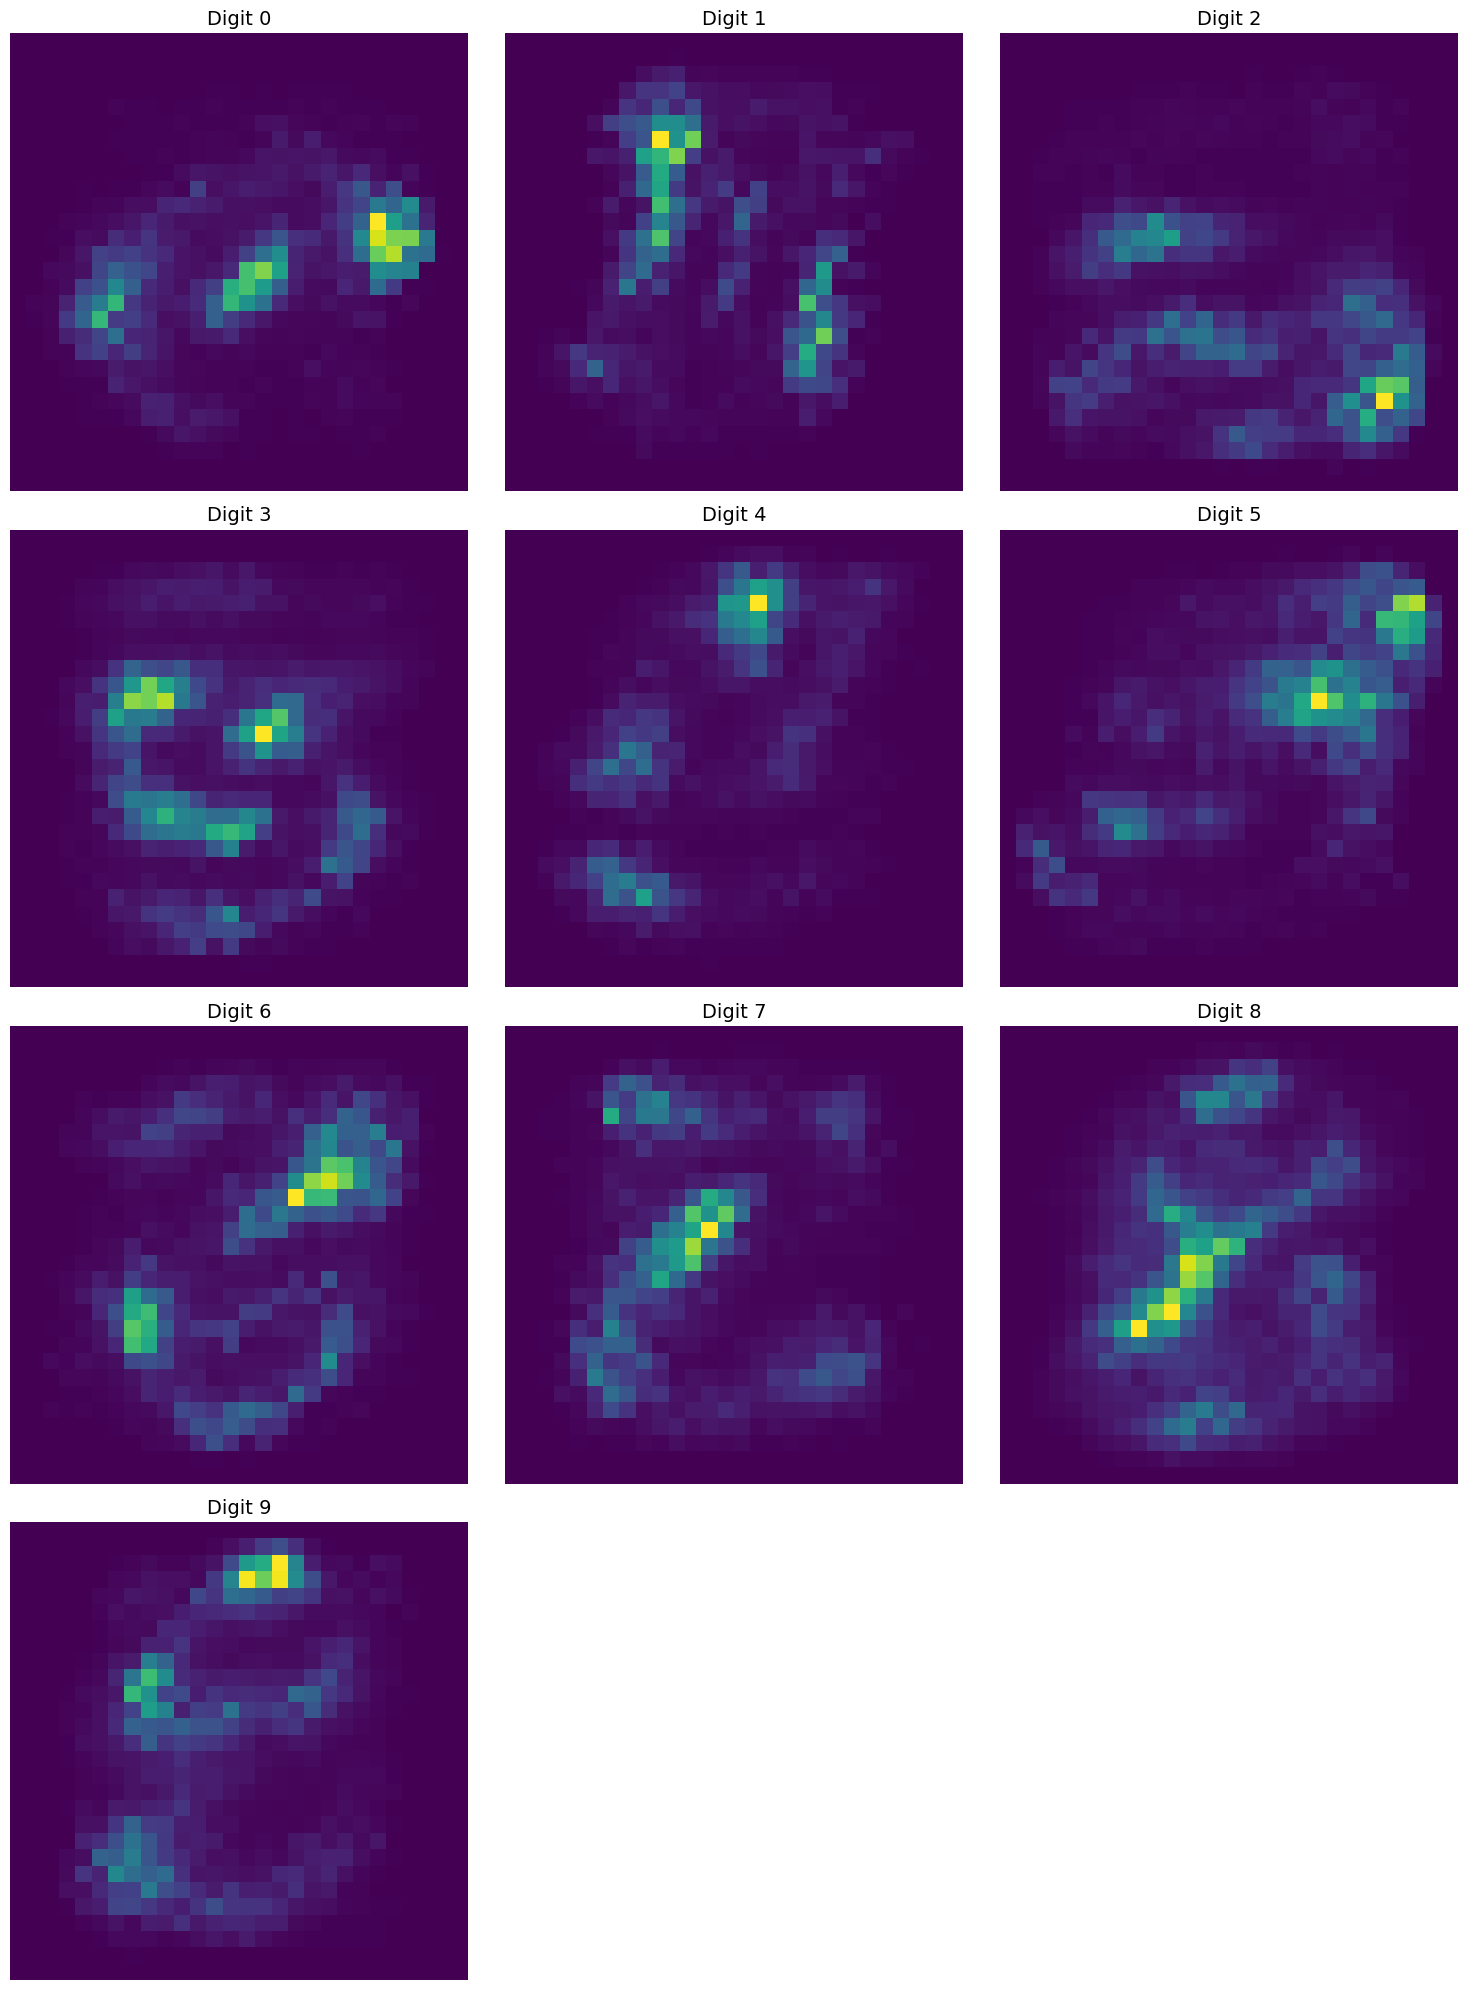

In [169]:
# visualize feature importances for all trained digits

rf_trainer.visualize_all_digits_feature_importance(grid_size=(28, 28))

### Aggregated Feature Importance: Unified Insights Across Digits

The aggregated feature importance heatmap combines insights from all one-vs-all models, giving us a unified view of which pixels consistently contribute to predictions across all digits. This global perspective highlights regions of the input space that are universally significant, irrespective of the specific digit being classified.

#### Observations:
1. **Concentration in Central Regions**: The central regions of the image exhibit the highest feature importance. This aligns with the fact that most handwritten digits share structural elements concentrated toward the center, making these pixels crucial for distinguishing between digits.
2. **Shared Importance Patterns**: The aggregated heatmap emphasizes pixels that likely contribute to multiple digits' classification. For instance:
   - **Upper Circular Areas**: Likely influenced by digits like 6, 8, and 9, which have overlapping loops or curves.
   - **Diagonal and Vertical Strokes**: Significant for distinguishing digits like 7, 4, and 1.
3. **Lower Peripheral Regions**: These areas show comparatively low importance, consistent with the observation that background or outer regions often contribute less to meaningful variations across digits.

#### Implications:
The aggregated view is invaluable for identifying **commonalities** in feature importance across digits. This allows us to refine our feature selection processes, focusing on consistently significant pixels while potentially discarding those with minimal contributions.

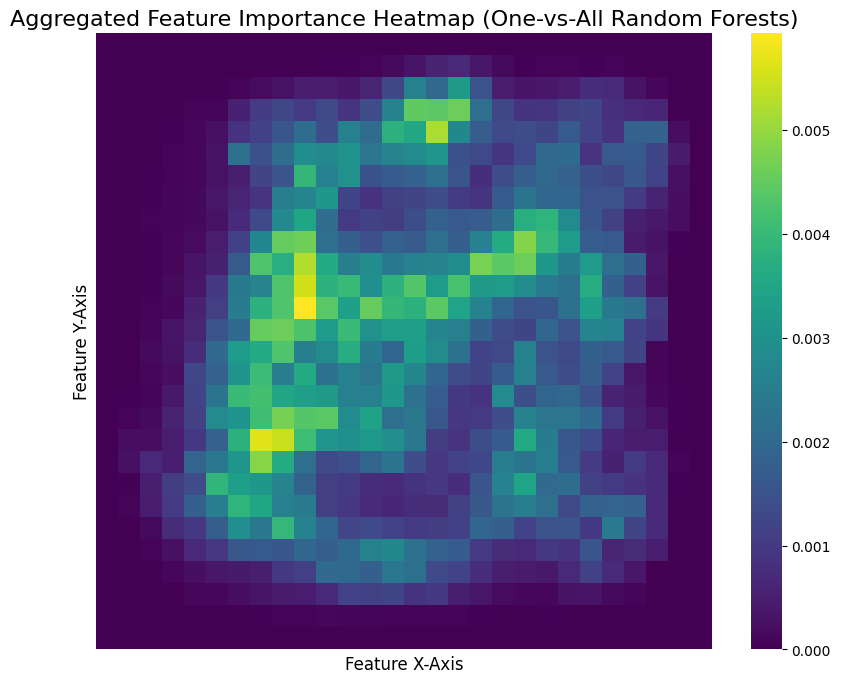

In [170]:
# step 5: visualize aggregated feature importances

rf_trainer.visualize_aggregated_importances(grid_size=(28, 28))

### 5.2.2.2. Dynamic Feature Importance: Random Forest Feature Elimination

#### Understanding RFE Rankings

The outcome of Recursive Feature Elimination (RFE) is a **ranking of features** based on their importance to the model's performance. This ranking is dynamic, as RFE evaluates features iteratively by removing the least significant ones and retraining the model.

#### What Do RFE Rankings Mean?
- **Rank 1**: Features ranked 1 are deemed the most important. These are the features that remain in the model even after most of the less relevant features are eliminated. They form the **core subset** that the model relies on for its predictions.
- **Higher Ranks (e.g., 2, 3, etc.)**: Features with higher ranks are progressively less critical to the model’s performance. They contribute to predictions but are more likely to be redundant or have overlapping importance with other features.

#### Why Are There Multiple Features with the Same Rank?
At each step, RFE evaluates features based on their contribution to the model and eliminates the least important ones. However, several features may share the same level of importance in a specific iteration. For example:
- If two features are highly correlated, removing one may not significantly impact the model, resulting in both being assigned the same rank.
- Similarly, if features contribute equally to splitting nodes in tree-based models, RFE might group them under the same rank.

#### Key Insight
RFE rankings offer a **hierarchical view** of feature importance. They help identify not just individual important features but also groups of features that collectively impact the model. This contrasts with static feature importance methods, which provide a fixed ranking without iterative refinement.

In [176]:
from sklearn.feature_selection import RFE

class RFERandomForest:
    def __init__(self, rf_trainer, X_train, y_train, n_per_digit=100, random_state=42):
        """
        Initializes the RFE class using the results from the one-vs-all Random Forests.
        
        Parameters:
        - rf_trainer: Instance of OneVsAllRandomForest, containing trained RF models and feature importances.
        - X_train: np.ndarray, feature matrix.
        - y_train: np.ndarray, true labels.
        - n_per_digit: int, number of samples to include per digit in the subset.
        - random_state: int, seed for reproducibility.
        """
        self.rf_trainer = rf_trainer
        self.X_train = X_train
        self.y_train = y_train
        self.n_per_digit = n_per_digit
        self.random_state = random_state
        self.subset_X = None
        self.subset_y = None
        self.rfe_results = {}

    def create_balanced_subset(self):
        """
        Creates a balanced subset of the training data with equal representation for each digit.
        """
        mask = create_balanced_subset_mask(self.y_train, self.n_per_digit, self.random_state)
        self.subset_X = self.X_train[mask]
        self.subset_y = self.y_train[mask]
        print(f"Balanced subset created: {len(self.subset_y)} samples, {len(np.unique(self.subset_y))} classes.")

    def perform_rfe_on_rf(self, n_features_to_select=None):
        """
        Performs RFE on the trained one-vs-all Random Forest models using the balanced subset.
        
        Parameters:
        - n_features_to_select: int or None, number of features to retain. Defaults to 50% of the feature count.
        """
        if self.subset_X is None or self.subset_y is None:
            raise ValueError("Balanced subset not created. Call `create_balanced_subset()` first.")

        # Default number of features to retain
        if n_features_to_select is None:
            n_features_to_select = self.subset_X.shape[1] // 2

        for model_name, rf_model in self.rf_trainer.rf_models.items():
            digit = int(model_name.split("_")[-1])  # Extract digit from the model name
            print(f"Performing RFE for {model_name} (digit {digit})...")

            # Create binary labels for the subset: True for the current digit, False for others
            y_binary_subset = (self.subset_y == digit).astype(int)

            # Initialize and perform RFE
            rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select, step=1)
            rfe.fit(self.subset_X, y_binary_subset)

            # Store RFE results
            self.rfe_results[model_name] = {
                "support": rfe.support_,  # Boolean mask of selected features
                "ranking": rfe.ranking_  # Feature rankings (1 = selected)
            }
            print(f"RFE for {model_name} completed: {sum(rfe.support_)} features selected.")

    def get_top_features(self, model_name):
        """
        retrieves the selected features for a specific model after RFE.
        
        parameters:
            - model_name: str, the name of the one-vs-all Random Forest model.
        
        returns:
            - selected_features: np.ndarray, boolean mask of selected features.
        """
        if model_name not in self.rfe_results:
            raise ValueError(f"RFE results for {model_name} not found. Ensure RFE was performed.")
        return self.rfe_results[model_name]["support"]

    def get_top_features_all_digits(self):
        """
        retrieves the selected features for all digits after RFE.
        """
        all_top_features = {}
        for model_name in self.rf_trainer.rf_models.keys():
            all_top_features[model_name] = self.get_top_features(model_name)
        return all_top_features

    def visualize_ranked_features_per_digit_rfe(self, grid_size=(28, 28), n_cols=3, cmap="magma"):
        """
        Visualizes ranked features for each digit by embedding rankings into the original image grid,
        displayed in a 3x3 grid layout. Features ranked 1 (most important) are highlighted distinctly.

        Parameters:
            - grid_size: tuple, dimensions of the feature grid (e.g., (28, 28) for MNIST).
            - n_cols: int, number of columns for the grid layout.
            - cmap: str, color map scheme for the heatmap.

        Returns:
        - None. Displays the images with ranked features embedded for each digit.
        """
        if self.subset_X is None or self.rfe_results is None:
            raise ValueError("RFE results or balanced subset not found. Ensure RFE has been performed.")

        rfe_results = self.rfe_results
        digits = sorted(int(model_name.split("_")[-1]) for model_name in rfe_results.keys())

        n_digits = len(digits)
        n_rows = (n_digits + n_cols - 1) // n_cols  # Compute the number of rows (rounding up)

        # Create a grid for plots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axes = axes.flatten()

        for i, digit in enumerate(digits):
            ax = axes[i]
            model_name = f"best_rf_{digit}"
            rankings = rfe_results[model_name]["ranking"]  # Get the feature rankings (1 = selected)

            # Normalize rankings to invert the scale (1 becomes highest intensity)
            max_rank = rankings.max()
            normalized_rankings = max_rank - rankings  # Higher ranks (e.g., 1) become higher intensities
            normalized_rankings = normalized_rankings / normalized_rankings.max()  # Scale to [0, 1]

            # Reshape normalized rankings into the image grid
            reshaped_rankings = normalized_rankings.reshape(grid_size)

            # Plot heatmap
            sns.heatmap(
                reshaped_rankings,
                annot=False,
                cmap=cmap,
                cbar=True,
                square=True,
                xticklabels=False,
                yticklabels=False,
                ax=ax,
                vmin=0,
                vmax=1  # Ensure proper scaling for all heatmaps
            )
            ax.set_title(f"Digit {digit} (RFE Rankings)", fontsize=14)
            ax.axis("off")

        # Turn off unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()
    
    def visualize_aggregated_features(self, grid_size=(28, 28)):
        """
        visualizes the aggregated top features across all digits.
        """
        aggregated_features = np.zeros(self.subset_X.shape[1])

        # sum the selected features across all RFE results
        for results in self.rfe_results.values():
            aggregated_features += results["support"]

        # normalize by the number of models
        aggregated_features /= len(self.rfe_results)

        # reshape into a grid
        aggregated_features_grid = aggregated_features.reshape(grid_size)

        # plot heatmap
        plt.figure(figsize=(8, 8))
        sns.heatmap(
            aggregated_features_grid,
            annot=False,
            cmap="Reds",
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False
        )
        plt.title("Aggregated Top Features Across All Digits (RFE)", fontsize=16)
        plt.xlabel("Feature X-Axis", fontsize=12)
        plt.ylabel("Feature Y-Axis", fontsize=12)
        plt.show()

In [177]:
# step 1: Initialize the RFE class

rfe_trainer = RFERandomForest(
    rf_trainer=rf_trainer,  # Instance of OneVsAllRandomForest
    X_train=X_train,
    y_train=y_train,
    n_per_digit=100,  # Subset size per digit
    random_state=42
)

In [178]:
# step 2: create a balanced subset

rfe_trainer.create_balanced_subset()

Balanced subset created: 1000 samples, 10 classes.


In [179]:
# step 3: perform RFE
# retain top 30% of features (recall from EDA that roughly 30% of the features are non-zero for each class)

rfe_trainer.perform_rfe_on_rf(n_features_to_select=262)

Performing RFE for best_rf_0 (digit 0)...
RFE for best_rf_0 completed: 262 features selected.
Performing RFE for best_rf_1 (digit 1)...
RFE for best_rf_1 completed: 262 features selected.
Performing RFE for best_rf_2 (digit 2)...
RFE for best_rf_2 completed: 262 features selected.
Performing RFE for best_rf_3 (digit 3)...
RFE for best_rf_3 completed: 262 features selected.
Performing RFE for best_rf_4 (digit 4)...
RFE for best_rf_4 completed: 262 features selected.
Performing RFE for best_rf_5 (digit 5)...
RFE for best_rf_5 completed: 262 features selected.
Performing RFE for best_rf_6 (digit 6)...
RFE for best_rf_6 completed: 262 features selected.
Performing RFE for best_rf_7 (digit 7)...
RFE for best_rf_7 completed: 262 features selected.
Performing RFE for best_rf_8 (digit 8)...
RFE for best_rf_8 completed: 262 features selected.
Performing RFE for best_rf_9 (digit 9)...
RFE for best_rf_9 completed: 262 features selected.


### Analyzing RFE Results Visualizations

One intriguing observation from the RFE visualizations is the appearance of contiguous regions of highly ranked pixels. This phenomenon is closely tied to the nature of both **image data** and the **RFE methodology**:

1. Spatial Correlations in Image Data:

   - In image-based datasets like EMNIST neighboring pixels often hold correlated information. For example, strokes in digits (lines, loops, or curves) are represented by clusters of pixels, where adjacent pixels work together to form meaningful features.  
   - RFE, by design, evaluates the **collective impact** of features on the model’s performance. When it encounters spatially correlated pixels, it tends to select multiple pixels in the same region because removing them together significantly affects the model’s accuracy. This naturally results in the selection of **contiguous regions** rather than isolated, scattered pixels.

3. Iterative Feature Elimination and Refinement: 

   - RFE eliminates features iteratively, retraining the model at each step and reevaluating the importance of the remaining features. This process ensures that feature interactions are considered dynamically.  
   - During this iterative refinement, clusters of interdependent pixels are often preserved together, as their combined influence on the model’s decision-making is stronger than that of any individual pixel. This leads to **smooth and regional patterns** in the RFE rankings.

5. Contrast with `feature_importances_`:  
   - The `feature_importances_` attribute of Random Forest focuses on the **individual contribution** of each feature (pixel), assigning importance based on metrics like impurity reduction. This method ignores dependencies between features, often producing sharp, scattered highlights in the visualization.  
   - In contrast, RFE evaluates **groups of features** in the context of the model’s overall performance, which smooths out importance and emphasizes regions rather than isolated pixels.

6. Model Behavior on Image Data:

   - For images, certain regions (e.g., the loops in an 8 or the stem of a 7) are inherently more critical for distinguishing digits. RFE captures these regions because they often consist of multiple interdependent pixels working together.  


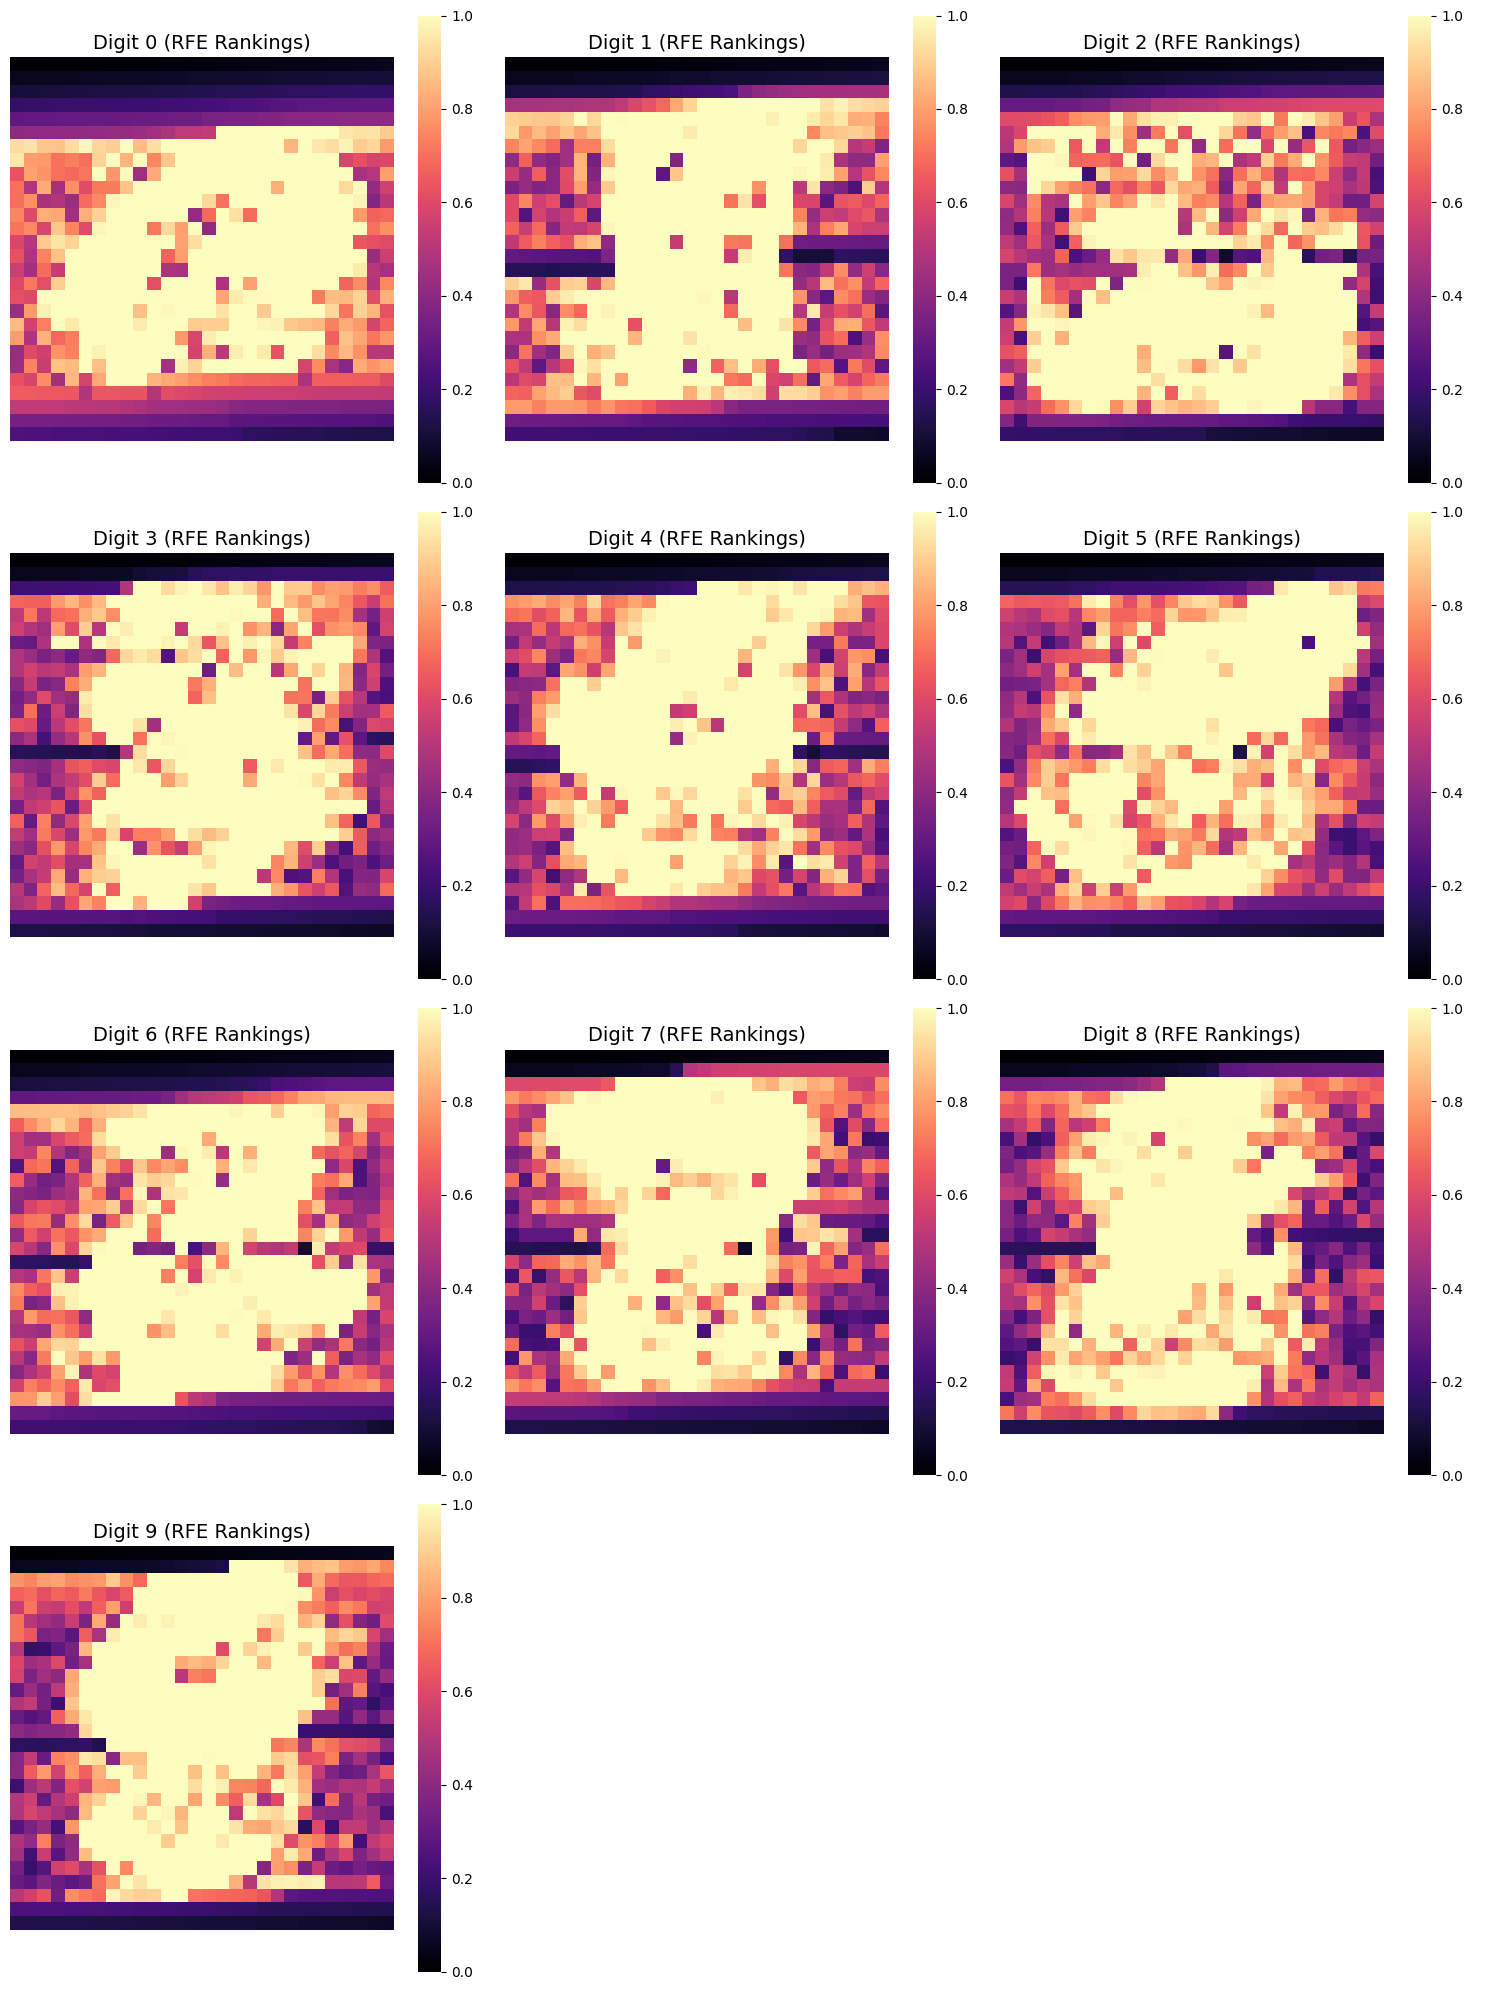

In [180]:
# step 4: visualize RFE results per digit

rfe_trainer.visualize_ranked_features_per_digit_rfe()

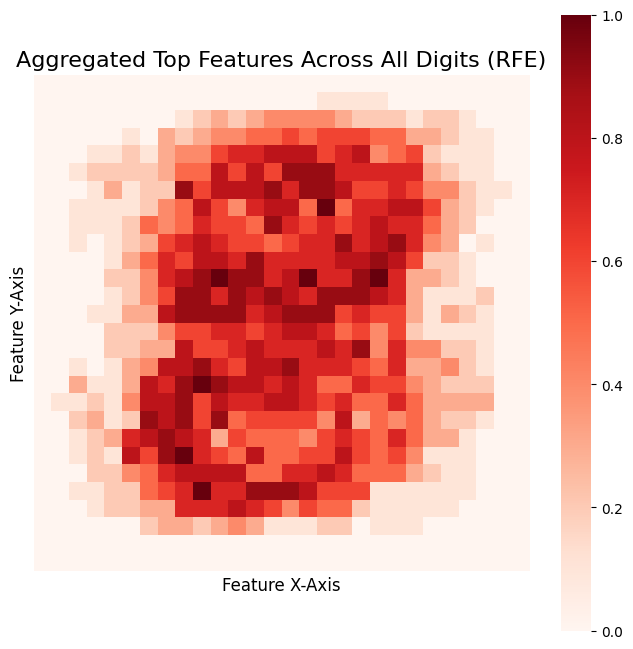

In [181]:
# step 5: visualize aggregated RFE results

rfe_trainer.visualize_aggregated_features(grid_size=(28, 28))

## 5.3. Feature Selection and Retraining

Feature selection plays a pivotal role in improving the performance and efficiency of machine learning models, particularly in high-dimensional datasets like images. By identifying and retaining only the most relevant features, we can reduce computational costs, minimize overfitting, and improve interpretability without sacrificing accuracy. In this chapter, we have already explored various methods to understand feature importance through SHAP values, Random Forest's `feature_importances_` attribute, and Recursive Feature Elimination (RFE). These analyses have laid the groundwork for informed and strategic feature selection.

The importance of feature selection extends beyond this chapter. Once we have identified optimal feature subsets, we will retrain models using these features and evaluate their performance. This step not only highlights the effectiveness of each feature selection method but also informs our decisions for Chapter 6, where a multi-class classifier will be trained using the best-performing feature subsets. Ultimately, this systematic approach ensures that our models are resource-efficient, scalable, and capable of achieving high performance across diverse metrics.

### 5.3.1. Selecting Features Based on Different Methods

In this section, we perform the following in order:

- Using SHAP values, we aggregate the most impactful features based on the top fraction of importance across all images.
- For RFE, the top-ranked features are identified from all one-vs-all models and aggregated.
- From Random Forest, feature importance values are aggregated across all one-vs-all models, and the top features are retained.

In [183]:
def aggregate_shap_results(shap_values, top_n_fraction=0.3):
    """
    Aggregates SHAP results by identifying the top features across all images.
    
    Parameters:
    - shap_values: np.ndarray, SHAP values for the dataset (n_samples, n_features).
    - top_n_fraction: float, fraction of features to retain.
    
    Returns:
    - top_features_shap: list of top feature indices.
    """
    n_features = shap_values.shape[1]
    top_n = int(n_features * top_n_fraction)
    top_features_shap = compute_top_features(shap_values, top_n=top_n)
    return [idx for idx, _ in top_features_shap]


def aggregate_rf_feature_importances_from_trainer(rf_trainer, method="mean"):
    """
    Aggregates feature importances from the OneVsAllRandomForest object.
    
    Parameters:
    - rf_trainer: Instance of OneVsAllRandomForest with normalized feature importances computed.
    - method: str, method to aggregate ("mean", "sum", or "max").
    
    Returns:
    - top_features_rf: list of top feature indices based on aggregated feature importance.
    """
    if rf_trainer.aggregated_importances is None:
        rf_trainer.aggregate_feature_importances(method=method)
    
    n_features = len(rf_trainer.aggregated_importances)
    top_n = int(n_features * 0.3)  # Top 30% of features
    top_features_rf = np.argsort(rf_trainer.aggregated_importances)[-top_n:][::-1]
    return top_features_rf


def aggregate_rfe_results_from_trainer(rfe_trainer):
    """
    Aggregates selected features from the RFERandomForest object.
    
    Parameters:
    - rfe_trainer: Instance of RFERandomForest with RFE results computed.
    
    Returns:
    - top_features_rfe: list of top feature indices based on RFE support aggregation.
    """
    aggregated_support = np.zeros(rfe_trainer.subset_X.shape[1])

    # Sum the selected features across all RFE results
    for results in rfe_trainer.rfe_results.values():
        aggregated_support += results["support"]  # Boolean mask of selected features

    # Get top 30% of features based on selection frequency
    top_n = int(len(aggregated_support) * 0.3)
    top_features_rfe = np.argsort(aggregated_support)[-top_n:][::-1]
    return top_features_rfe


def aggregate_all_feature_importance(shap_values, rf_trainer, rfe_trainer, top_n_fraction=0.3):
    """
    Aggregates feature importance results from SHAP, Random Forest, and RFE.
    
    Parameters:
    - shap_values: np.ndarray, SHAP values for the dataset (n_samples, n_features).
    - rf_trainer: Instance of OneVsAllRandomForest.
    - rfe_trainer: Instance of RFERandomForest.
    - top_n_fraction: float, fraction of features to retain.
    
    Returns:
    - aggregated_results: dict containing top features from SHAP, RF, and RFE.
    """
    print("Aggregating SHAP results...")
    top_features_shap = aggregate_shap_results(shap_values, top_n_fraction=top_n_fraction)
    
    print("Aggregating Random Forest feature importances...")
    top_features_rf = aggregate_rf_feature_importances_from_trainer(rf_trainer, method="mean")
    
    print("Aggregating RFE results...")
    top_features_rfe = aggregate_rfe_results_from_trainer(rfe_trainer)
    
    aggregated_results = {
        "SHAP": top_features_shap,
        "Random Forest": top_features_rf,
        "RFE": top_features_rfe
    }
    return aggregated_results

In [184]:
aggregated_features = aggregate_all_feature_importance(
    shap_values=shap_values,  # Precomputed SHAP values
    rf_trainer=rf_trainer,   # Pretrained OneVsAllRandomForest instance
    rfe_trainer=rfe_trainer, # Pretrained RFERandomForest instance
    top_n_fraction=0.3       # Retain top 30% features
)

Aggregating SHAP results...
Aggregating Random Forest feature importances...
Aggregating RFE results...


### 5.3.2. Comparing Feature Sets

Now that we have aggreagted the results from different feature selection methods, let us explore how they look and compare. Particularly, how about evaluating intersections between feature sets obtained from SHAP, RFE, and Random Forest? This includes pairwise overlaps (e.g., SHAP & RFE) and the intersection of all three methods. Also let us visualize the overlapping and unique features to see a clear understanding of their relationship.

In [185]:
def compare_feature_importance_methods(aggregated_features):
    """
    Compares the feature sets from SHAP, Random Forest, and RFE.
    
    Parameters:
    - aggregated_features: dict, containing top features from SHAP, RF, and RFE.

    Returns:
    - comparison_results: dict, showing overlaps and unique features for each method.
    """
    shap_features = set(aggregated_features["SHAP"])
    rf_features = set(aggregated_features["Random Forest"])
    rfe_features = set(aggregated_features["RFE"])

    comparison_results = {
        "SHAP & RF Overlap": shap_features & rf_features,
        "SHAP & RFE Overlap": shap_features & rfe_features,
        "RF & RFE Overlap": rf_features & rfe_features,
        "All Overlap": shap_features & rf_features & rfe_features,
        "SHAP Unique": shap_features - (rf_features | rfe_features)
    }

    return comparison_results


def summarize_comparison_results(comparison_results):
    """
    Summarizes the comparison results for easier interpretation.
    
    Parameters:
    - comparison_results: dict, results of feature comparison.
    
    Returns:
    - summary: dict, containing counts of unique and overlapping features.
    """
    summary = {
        "SHAP & RF Overlap Count": len(comparison_results["SHAP & RF Overlap"]),
        "SHAP & RFE Overlap Count": len(comparison_results["SHAP & RFE Overlap"]),
        "RF & RFE Overlap Count": len(comparison_results["RF & RFE Overlap"]),
        "All Overlap Count": len(comparison_results["All Overlap"]),
        "SHAP Unique Count": len(comparison_results["SHAP Unique"])
    }

    return summary


def visualize_comparison_results(comparison_results, grid_size=(28, 28)):
    """
    Visualizes the overlapping and unique features as heatmaps.
    
    Parameters:
    - comparison_results: dict, results of feature comparison.
    - grid_size: tuple, dimensions of the feature grid (e.g., (28, 28) for MNIST).
    
    Returns:
    - None. Displays heatmaps for each category of comparison.
    """
    categories = [
        ("SHAP & RF Overlap", comparison_results["SHAP & RF Overlap"]),
        ("SHAP & RFE Overlap", comparison_results["SHAP & RFE Overlap"]),
        ("RF & RFE Overlap", comparison_results["RF & RFE Overlap"]),
        ("All Overlap", comparison_results["All Overlap"]),
        ("SHAP Unique", comparison_results["SHAP Unique"])
    ]

    n_cols = 3
    n_rows = (len(categories) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, (title, feature_set) in enumerate(categories):
        ax = axes[i]
        heatmap_data = np.zeros(grid_size[0] * grid_size[1])
        heatmap_data[list(feature_set)] = 1  # Mark features in the feature set
        heatmap_data = heatmap_data.reshape(grid_size)

        sns.heatmap(
            heatmap_data,
            annot=False,
            cmap="coolwarm",
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=ax,
        )
        ax.set_title(title, fontsize=14)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [186]:
comparison_results = compare_feature_importance_methods(aggregated_features)

In [187]:
summary = summarize_comparison_results(comparison_results)
print("Comparison Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

Comparison Summary:
SHAP & RF Overlap Count: 235
SHAP & RFE Overlap Count: 235
RF & RFE Overlap Count: 169
All Overlap Count: 169
SHAP Unique Count: 279


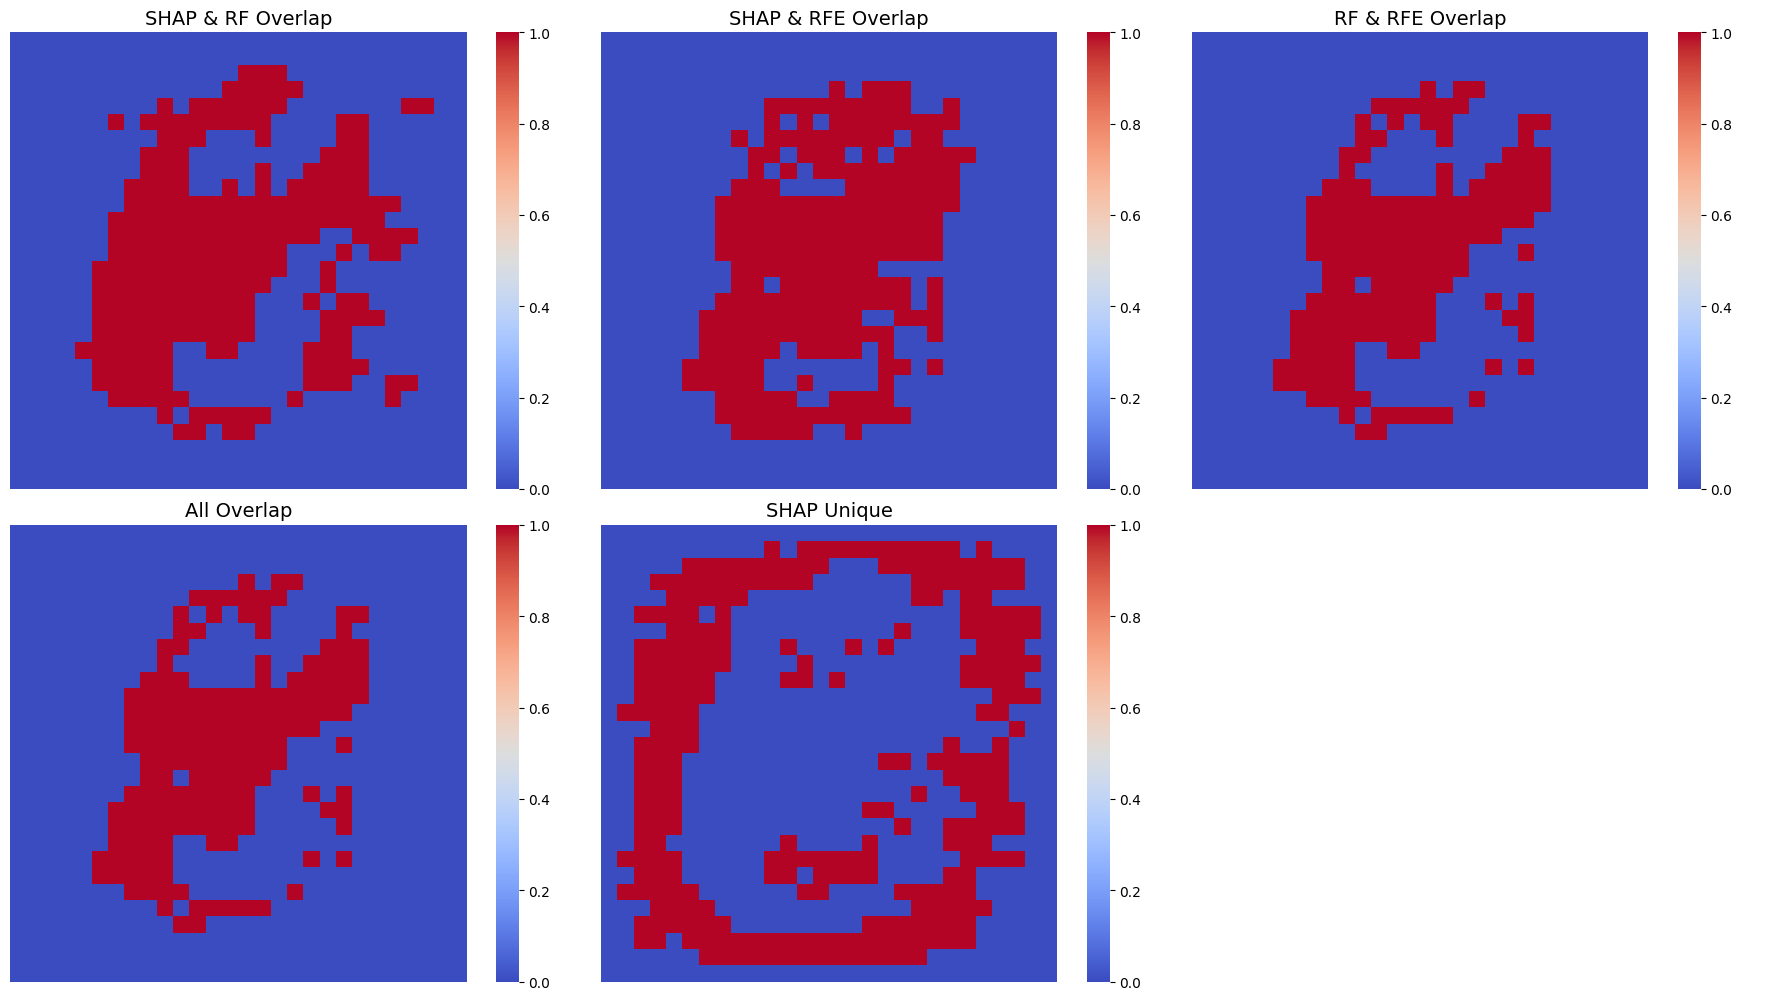

In [188]:
visualize_comparison_results(comparison_results, grid_size=(28, 28))

### 5.3.3. Benchmarking Feature Sets: Retraining and Evaluating Models

Using the feature subsets derived from SHAP, RFE, and Random Forest, as well as their combinations, we retrain XGBoost models. Also, the performance of each model is compared based on metrics such as precision, recall, F1-score, accuracy, and ROC AUC, alongside training times.

Before proceeding, it is important to highlight a key choice we have made for retraining. We are increasing the `n_estimators` parameter by 30% compared to the best XGBoost model from Chapter 3. This icrease is offset with a 70% reduction in the feature space the model needs to explore. This decision is guided by optimization lessons, aiming to balance computational cost while maintaining performance. By keeping the overall computational cost roughly the same (actually less), we seek to achieve comparable or even better results. Whether this approach pays off or requires revision will be evaluated once we analyze the outcomes.

In [189]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
import time

def train_xgboost(model_params, X_train, y_train):
    """
    Trains an XGBoost model with given parameters on the provided dataset.

    Parameters:
    - model_params: dict, parameters for XGBoost.
    - X_train: np.ndarray, feature matrix.
    - y_train: np.ndarray, binary labels (8-vs-all).

    Returns:
    - model: Trained XGBoost model.
    - train_time: float, training time in seconds.
    """
    start_time = time.time()
    model = XGBClassifier(**model_params)
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    return model, train_time


def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained model on the test dataset.

    Parameters:
    - model: Trained XGBoost model.
    - X_test: np.ndarray, test feature matrix.
    - y_test: np.ndarray, test binary labels (8-vs-all).

    Returns:
    - metrics: dict, containing evaluation metrics (accuracy, precision, recall, F1-score, ROC AUC).
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class (8)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
    }

    return metrics


def train_and_evaluate(feature_indices, X_train, y_train, X_test, y_test, base_params, increase_rate=0.3):
    """
    Trains and evaluates an XGBoost model for a specific feature subset.

    Parameters:
    - feature_indices: list, indices of selected features.
    - X_train, X_test: np.ndarray, feature matrices for training and testing.
    - y_train, y_test: np.ndarray, binary labels (8-vs-all) for training and testing.
    - base_params: dict, base parameters of the best XGBoost model.
    - increase_rate: float, percentage to increase n_estimators.

    Returns:
    - model: Trained XGBoost model.
    - metrics: dict, evaluation metrics.
    - train_time: float, training time in seconds.
    """
    # Reduce the feature set
    X_train_reduced = X_train[:, feature_indices]
    X_test_reduced = X_test[:, feature_indices]

    # Update model parameters
    model_params = base_params.copy()
    model_params["n_estimators"] = int(base_params["n_estimators"] * (1 + increase_rate))

    # Train the model
    model, train_time = train_xgboost(model_params, X_train_reduced, y_train)

    # Evaluate the model
    metrics = evaluate_model(model, X_test_reduced, y_test)

    return model, metrics, train_time

In [190]:
# Prepare feature sets (precomputed)
feature_sets = {
    "SHAP": aggregated_features["SHAP"],
    "RF": aggregated_features["Random Forest"],
    "RFE": aggregated_features["RFE"],
    "SHAP_RF": list(comparison_results["SHAP & RF Overlap"]),
    "SHAP_RFE": list(comparison_results["SHAP & RFE Overlap"]),
    "RF_RFE": list(comparison_results["RF & RFE Overlap"]),
    "All_Overlap": list(comparison_results["All Overlap"])
}

# Load the best parameters for XGBoost
base_params = {
    "n_estimators": best_estimators_dict["best_xgb"].n_estimators,
    "max_depth": best_estimators_dict["best_xgb"].max_depth,
    "learning_rate": best_estimators_dict["best_xgb"].learning_rate,
    "subsample": best_estimators_dict["best_xgb"].subsample,
    "colsample_bytree": best_estimators_dict["best_xgb"].colsample_bytree,
    "gamma": best_estimators_dict["best_xgb"].gamma,
    "random_state": 42
}

# Train and evaluate models for each feature set
results = {}
for group_name, feature_indices in feature_sets.items():
    print(f"Processing feature group: {group_name}...")
    model, metrics, train_time = train_and_evaluate(
        feature_indices=feature_indices,
        X_train=X_train,
        y_train=y_train_8,
        X_test=validation_X_train,
        y_test=validation_y_8,
        base_params=base_params,
        increase_rate=0.3
    )
    results[group_name] = {
        "model": model,
        "metrics": metrics,
        "train_time": train_time
    }
    print(f"Results for {group_name}:")
    print(metrics)
    print(f"Training Time: {train_time:.2f}s\n")

Processing feature group: SHAP...
Results for SHAP:
{'accuracy': 0.9954, 'precision': np.float64(0.9937888198757764), 'recall': np.float64(0.96), 'f1_score': np.float64(0.9766022380467956), 'roc_auc': np.float64(0.9996606666666666)}
Training Time: 22.42s

Processing feature group: RF...
Results for RF:
{'accuracy': 0.9943, 'precision': np.float64(0.9845837615621789), 'recall': np.float64(0.958), 'f1_score': np.float64(0.9711099847947289), 'roc_auc': np.float64(0.9992763333333333)}
Training Time: 6.47s

Processing feature group: RFE...
Results for RFE:
{'accuracy': 0.9935, 'precision': np.float64(0.9854620976116303), 'recall': np.float64(0.949), 'f1_score': np.float64(0.9668874172185431), 'roc_auc': np.float64(0.9992636666666667)}
Training Time: 10.05s

Processing feature group: SHAP_RF...
Results for SHAP_RF:
{'accuracy': 0.9934, 'precision': np.float64(0.9854469854469855), 'recall': np.float64(0.948), 'f1_score': np.float64(0.9663608562691132), 'roc_auc': np.float64(0.9993432222222223

In [191]:
# Combine `results` and metrics from `tuned_summary` for the final DataFrame

# Convert the `results` dictionary to a DataFrame
results_data = {
    group_name: {
        "Precision": data["metrics"]["precision"],
        "Recall": data["metrics"]["recall"],
        "F1-Score": data["metrics"]["f1_score"],
        "Accuracy": data["metrics"]["accuracy"],
        "ROC AUC": data["metrics"]["roc_auc"]
    }
    for group_name, data in results.items()
}

results_df = pd.DataFrame.from_dict(results_data, orient="index")

# Extract the metrics for `best_xgb` from `tuned_summary`
best_xgb_row = tuned_summary[tuned_summary['Model'] == 'best_xgb'].iloc[0]
best_xgb_data = {
    "Precision": best_xgb_row["Precision"],
    "Recall": best_xgb_row["Recall"],
    "F1-Score": best_xgb_row["F1-Score"],
    "Accuracy": best_xgb_row["Accuracy"],
    "ROC AUC": best_xgb_row["ROC AUC"]
}

# Add `best_xgb` as a row to the DataFrame
results_df.loc["best_xgb"] = best_xgb_data

# Return the final DataFrame
results_df

,Precision,Recall,F1-Score,Accuracy,ROC AUC
SHAP,0.993789,0.960,0.976602,0.9954,0.999661
RF,0.984584,0.958,0.971110,0.9943,0.999276
RFE,0.985462,0.949,0.966887,0.9935,0.999264
SHAP_RF,0.985447,0.948,0.966361,0.9934,0.999343
SHAP_RFE,0.985447,0.948,0.966361,0.9934,0.999034
RF_RFE,0.989605,0.952,0.970438,0.9942,0.998678
All_Overlap,0.989605,0.952,0.970438,0.9942,0.998678
best_xgb,0.985567,0.956,0.970558,0.9942,0.999505


#### Key Observations

The table below summarizes the performance of XGBoost models trained on features selected using SHAP, RFE, and Random Forest (RF) feature importance, as well as their intersections. These models are benchmarked against the best-tuned XGBoost model from Chapter 3. The best-tuned model (referred to as `best_xgb`) achieved competitive metrics and provided a benchmark for evaluating the efficacy of the feature selection methods.

As we see, the XGBoost trained on every group of selected features performs competitively against the benchmark XGBoost. More importantly, the SHAP-selected features actually outperform every model, including the XGBoost tuned on all features of the images. This demonstrates that selecting only the top 30% of features based on SHAP values is sufficient to train a highly performant XGBoost model, offering both efficiency and effectiveness in feature selection.

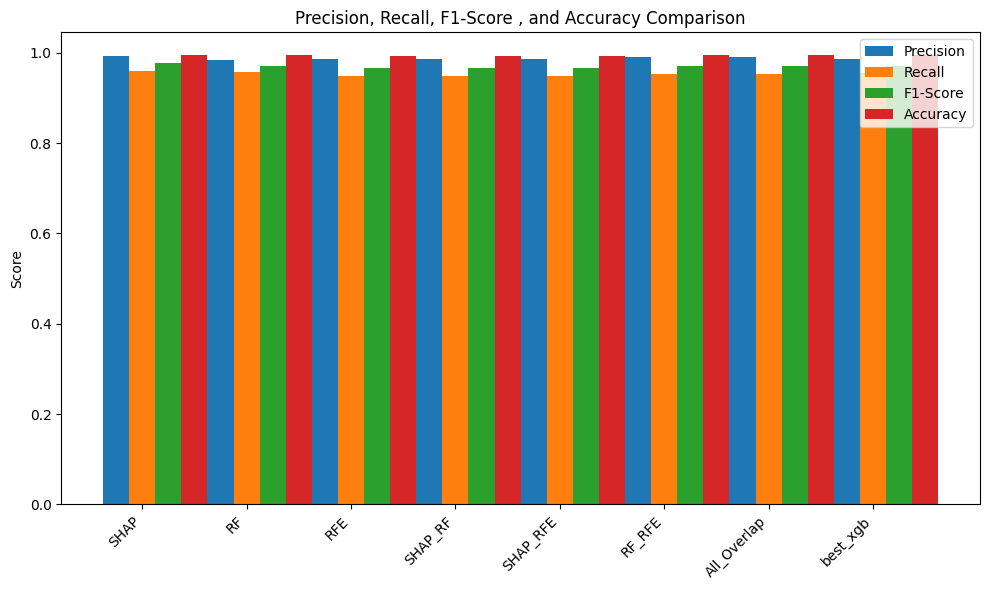

In [192]:
# Plot metrics comparison using the existing function
plot_metrics_comparison(results_df.reset_index().rename(columns={"index": "Model"}))

#### Lessons Learned and Looking Ahead

An important point to note is that while training XGBoost models in this section, we used only 30% of the features (based on SHAP, RFE, and other selection methods), representing roughly a 70% reduction in the feature space. To compensate, we increased the number of `n_estimators` in the tuned XGBoost from Chapter 3 by 30%. 

The results are striking: we achieved the same performance as the benchmark XGBoost (trained on the full feature set) and even outperformed it when using SHAP-selected features. The lesson here is clear—through careful analysis and optimization, we significantly reduced the cost of training (more than 60% feature space reduction) while maintaining or even improving performance with only a modest 30% increase in `n_estimators`. 

This demonstrates the value of strategic feature selection and optimization over an approach that relies on sheer brute computational power without regard for cost-benefit analysis. Analytical rigor, as opposed to indiscriminate resource allocation, yields not only efficiency but also superior outcomes.

Moving forward to Chapter 6, we will utilize the SHAP-selected feature set as our feature space for training a multi-class classifier. The rationale for our choice is justified by the results it has proven us capable of achieving. 

## 5.4. Understanding Errors Using Feature Importance

Using the feature importance analysis conducted in this chapter, we can shed light on the observed confusion between digit images, particularly those involving digit 1 (see Section 3.4.3). This confusion was initially attributed to factors such as the tilted or distorted appearances of digit 8, which resemble a thick, tilted digit 1. SHAP-based analysis and Random Forest feature importance together validate and expand on this hypothesis quantitatively. To make the discussion more tangible, below we visualize the same misclassified images, this time highlighting the top 30% of important pixels derived from their SHAP values.

Referring to the visualized feature importances obtained from the trained 1-vs-all and 8-vs-all Random Forests in Section 5.2.2.1, we can identify three contiguous regions of pixels that the Random Forest model considers highly significant. Two of these regions appear as tilted lines in the upper first quarter and lower fourth quarter of the feature importance plot for digit 1. A third region, which is relatively less important, appears in the middle. Interestingly, when examining the feature importance visualization for digit 8, we notice regions of importance that overlap with some key regions identified for digit 1. As discussed in Section 5.2.2.1, these overlapping regions contribute most to potential misclassifications for two main reasons.

First, the misclassified images of digit 8 exhibit geometric properties that are closely aligned with those of digit 1. Specifically, these images of digit 8, due to their tilted and narrow shapes, have overlapping regions of significance with digit 1 (as indicated by the Random Forest feature importance). This reflects a common issue in real-world data, where subtle variations or distortions in input can make classification particularly challenging.

Second, tree-based algorithms, such as Random Forests, can be susceptible to such challenging cases due to the way trees are constructed. The structure of a decision tree depends heavily on the random features selected for splitting and calculating cost functions. If the number of trees in the ensemble is not large enough, or if parameters such as the minimum number of features required for a split are not properly tuned, images near the decision boundary between their true class and a false class are more likely to be misclassified. In such cases, the selected features may inadvertently favor the wrong class, leading to increased errors.

### 5.4.1. A Future Endeavour: Trustworthiness, Robustness, And Adversarial Training

A Future Endeavour: Trustworthiness, Robustness, And Adversarial Training
Perhaps it is apt to touch on a topic related to robustness and noise. The misclassified cases visualized below have noise in them. Trees are not weak at all against noise. They show robust behavior against deviant cases thanks to their ensembling method and randomization in feature selection, making it hard for an adversary to craft noisy data in such a manner that their interested fraction of data passes through an ML system without getting detected or raising an alarm. Using an error analysis informed by feature importance analysis, as we are advocating for, will assist in training ML models that are robust (up to a certain point) against adversarial attacks.

Robustness and trustworthiness are critical themes that extend beyond this project and offer significant potential for future exploration. These areas can further enhance the reliability of machine learning models, particularly when dealing with noisy or adversarial data scenarios. For example, in adversarial training, carefully crafted perturbations or noise are added to training samples (e.g., modifying digit images subtly but intentionally to resemble other digits). These adversarial samples force the model to learn stronger decision boundaries and improve its resilience to similar attacks during deployment.

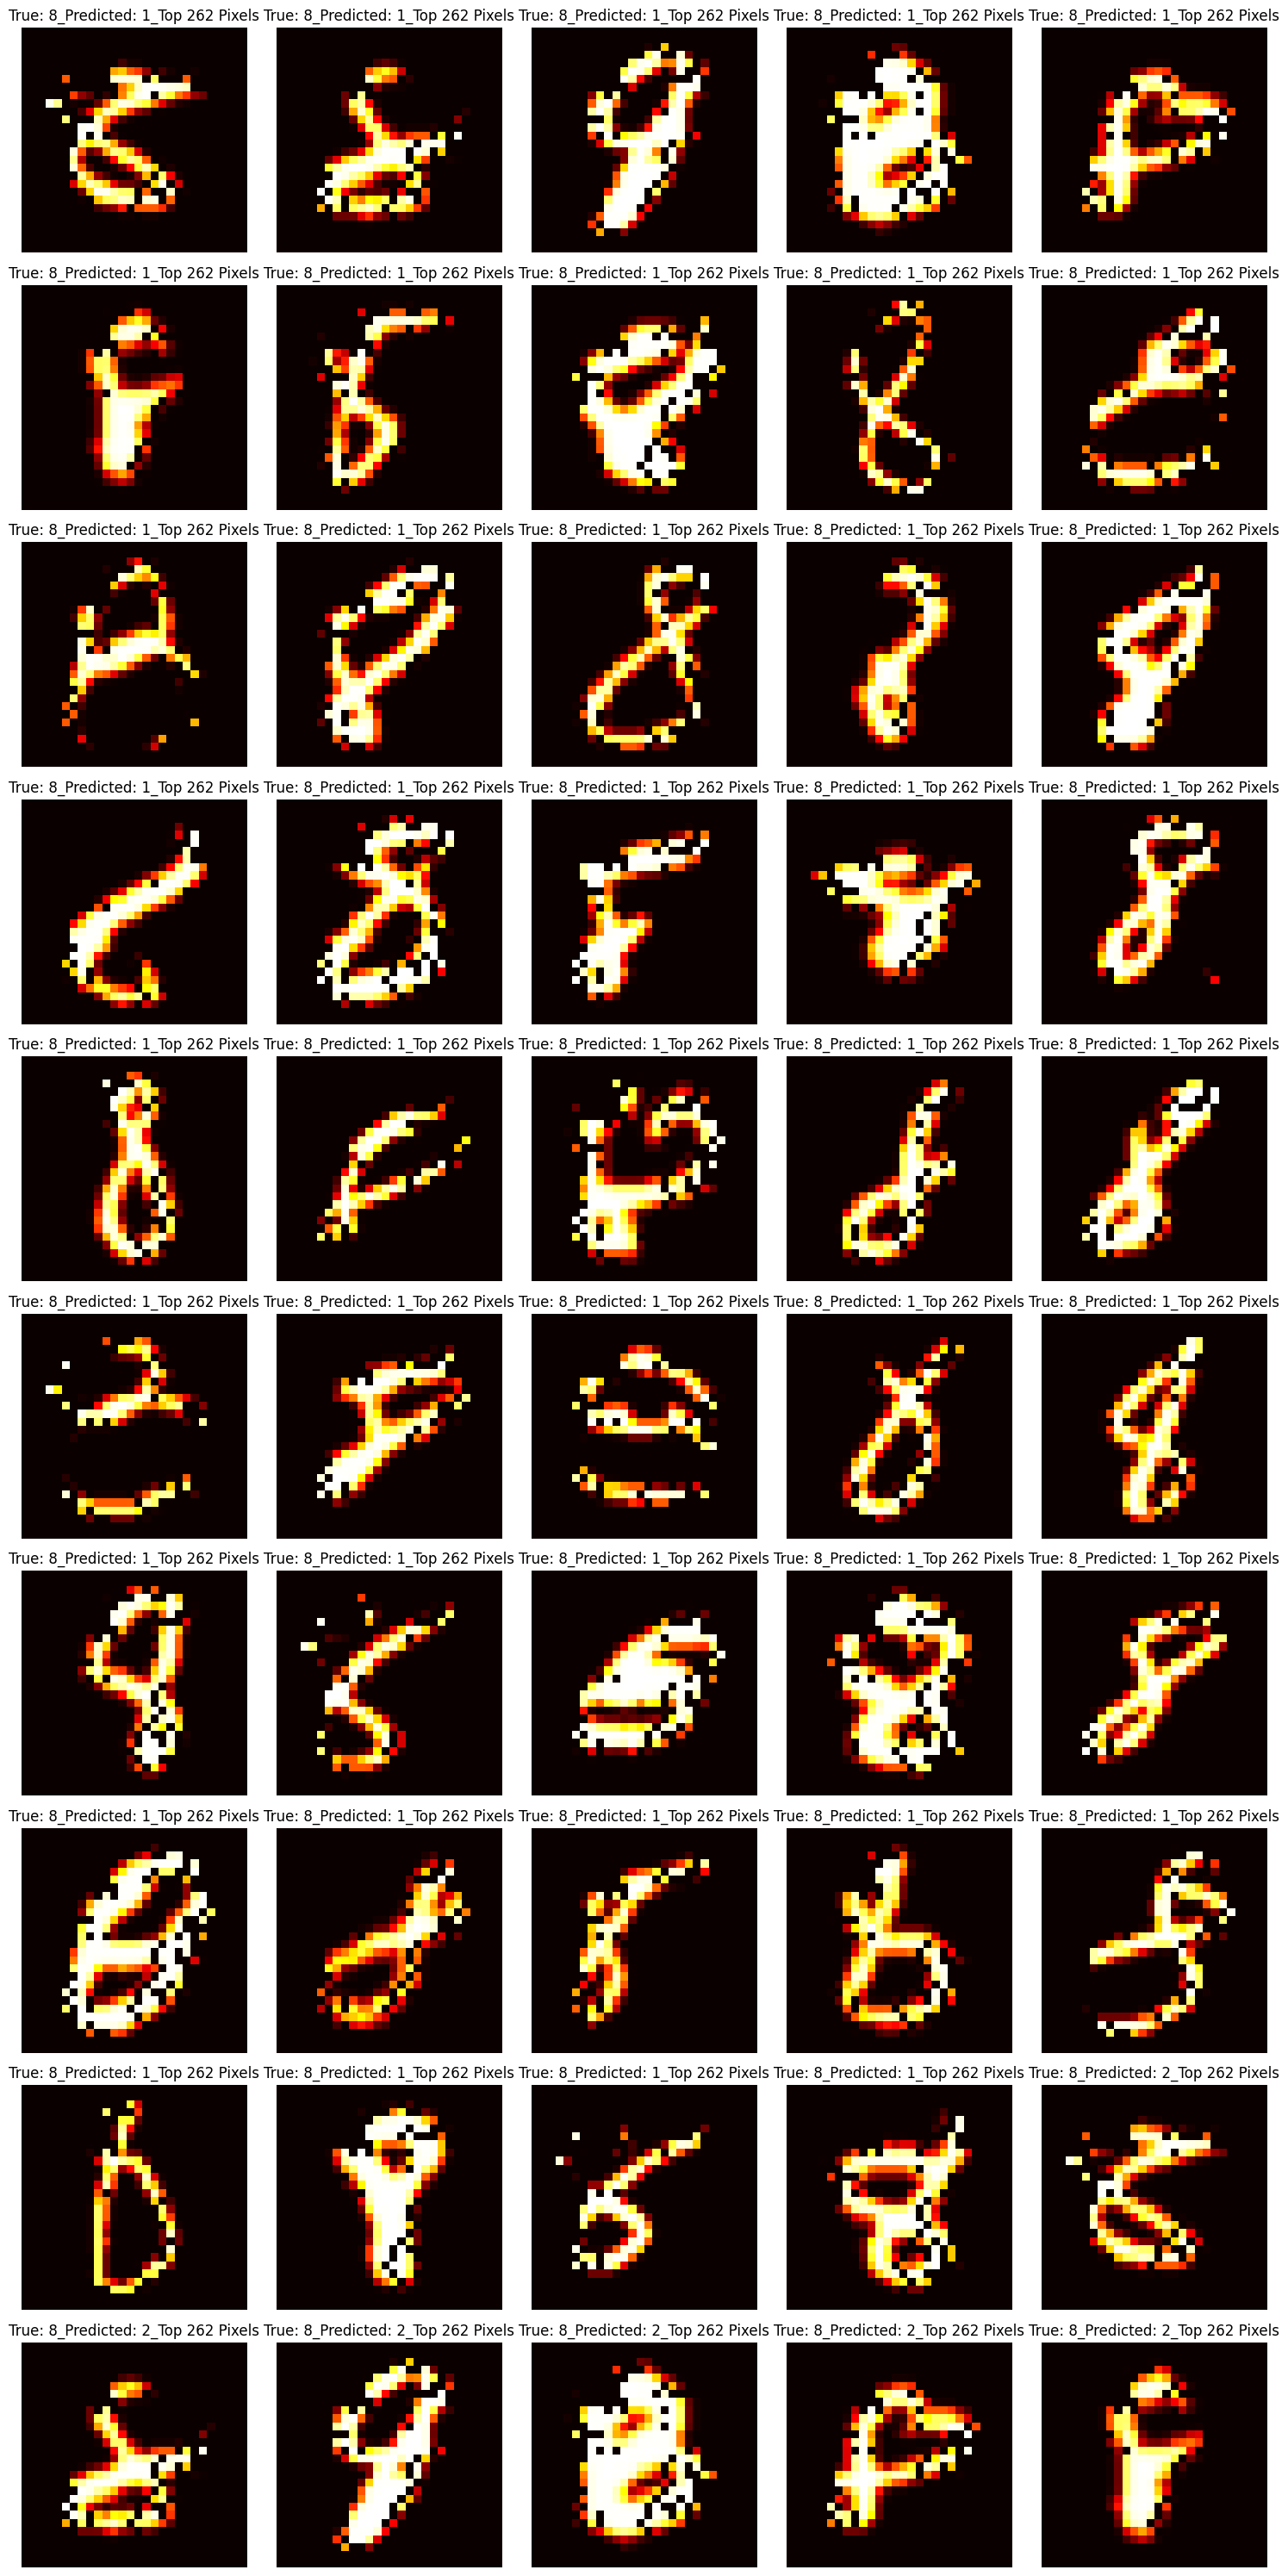

In [107]:
def visualize_misclassified_top_features_v3(misclassified_dict, model_name, validation_X, validation_y, top_features, top_n, grid_size=(28, 28), num_images=10):
    """
    Visualizes top N important features for misclassified images by a specific model.

    Parameters:
        - misclassified_dict: dict, dictionary containing misclassified indices.
        - model_name: str, the name of the model to analyze.
        - validation_X: np.ndarray, original validation images (n_samples, n_features).
        - validation_y: np.ndarray, true labels corresponding to the validation images.
        - top_features: list of tuples [(feature_index, count)], output from compute_top_features.
        - top_n: int, number of top features to retain for visualization.
        - grid_size: tuple, dimensions of the image grid (height, width).
        - num_images: int, number of images to visualize.

    Returns:
        - None
    """
    
    # gather all misclassified indices for the given model
    misclassified_indices = []
    false_labels = []
    for false_label, model_dict in misclassified_dict.items():
        if model_name in model_dict:
            misclassified_indices.extend(model_dict[model_name])
            false_labels.extend([false_label] * len(model_dict[model_name]))

    # extract the misclassified images and their true labels
    misclassified_images = validation_X[misclassified_indices]
    misclassified_labels = validation_y[misclassified_indices]

    # visualize the top N features for these misclassified images
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Round up
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(misclassified_images):
            # reshape image and create a mask for the top N features
            original_image = misclassified_images[i].reshape(grid_size)
            mask = np.zeros_like(original_image)

            for feature_index in [idx for idx, _ in top_features[:top_n]]:
                row, col = divmod(feature_index, grid_size[1])
                mask[row, col] = original_image[row, col]  # Retain only top N features

            # visualize the masked image
            ax.imshow(mask, cmap="hot", interpolation="nearest")
            ax.axis("off")
            ax.set_title(f"True: {misclassified_labels[i]}_Predicted: {false_labels[i]}_Top {top_n} Pixels")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_misclassified_top_features_v3(misclassified_dict_tuned, "best_xgb", validation_X_train, validation_y, top_features, top_n=262, grid_size=(28, 28), num_images=47)